In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt

# Set random seed for reproducibility
#np.random.seed(42)

# Generate two years of daily data
n_days =180
dates = pd.date_range(start="2023-01-01", periods=n_days, freq='D')

# Define a complicated ARMA process (ARMA(2,2) for example)
ar_params = np.array([1, -0.5, 0.25])  # AR terms (including lag-0)
ma_params = np.array([1, 0.4, -0.3])   # MA terms (including lag-0)
arma_process = ArmaProcess(ar_params, ma_params)

# Generate ARMA-based sales (raw values, not yet scaled)
sales_series = arma_process.generate_sample(nsample=n_days)

# Scale and transform to ensure positive integer values
base_sales = 100  # Base level of sales
sales_series = base_sales + (sales_series - sales_series.min()) * 10  # Scale up
sales_series = np.round(sales_series).astype(int)  # Ensure integer sales

# Introduce seasonality (weekends have higher sales)
weekend_multiplier = 1.3  # Increase by 30% on weekends
is_weekend = (dates.weekday >= 5)  # Saturday (5) and Sunday (6)
sales_series[is_weekend] = np.round(sales_series[is_weekend] * weekend_multiplier).astype(int)

# Create sales DataFrame
sales_data = pd.DataFrame({'Date': dates, 'Sales': sales_series})

# Compute weekly sales
sales_data['Week'] = sales_data['Date'].dt.to_period('W')
weekly_sales = sales_data.groupby('Week')['Sales'].sum()

# Compute the average weekly sales
avg_weekly_sales = weekly_sales.mean()

# Compute the approximate ratio of sales for each weekday
sales_data['Weekday'] = sales_data['Date'].dt.weekday  # Monday=0, Sunday=6
weekday_sales = sales_data.groupby('Weekday')['Sales'].sum()
weekday_ratio = weekday_sales / weekday_sales.sum()  # Normalize to get composition ratios

# Generate daily sales forecast
sales_forecast = sales_data[['Date', 'Weekday']].copy()
sales_forecast['Forecasted_Sales'] = (avg_weekly_sales * sales_forecast['Weekday'].map(weekday_ratio)).round().astype(int)

# Create a dataset containing both actual sales and forecasted sales
sales_comparison = sales_data[['Date', 'Sales']].copy()
sales_comparison['Forecasted_Sales'] = sales_forecast['Forecasted_Sales']

sales_comparison['Day_of_Week'] = sales_comparison['Date'].dt.weekday+1
sales_comparison['Week_Start_Date'] = sales_comparison['Date'] - pd.to_timedelta(sales_comparison['Date'].dt.weekday, unit='D')


# Define ordering parameters
#order_days = {0: 3, 2: 3, 3: 4}  # Order days: Monday (0), Wednesday (2), Thursday (3) with respective lead times
order_days = {0: 2, 2: 2, 3: 2,4:3}
#order_days = {1: 2, 4: 2, 5: 2,6:3}
#order_days = {0: 2, 3: 2, 4: 2,6:2}
#target_inventory = 500  # Target inventory level
initial_inventory = 200  # Initial inventory level

# Initialize columns
sales_comparison['Inventory_End'] = 0
sales_comparison['Order_Qty'] = 0
sales_comparison['Intake_Qty'] = 0
sales_comparison.loc[0, 'Inventory_End'] = initial_inventory  # Set initial inventory

# Iterate over the dataset to simulate ordering and inventory evolution
# Iterate over the dataset to simulate ordering and inventory evolution
for i in range(len(sales_comparison)):
    today = sales_comparison.loc[i, 'Date']
    weekday = today.weekday()

    # Determine future sales and intake before the next order arrives
    if weekday in order_days:
        lead_time = order_days[weekday]
        arrival_date = today + pd.Timedelta(days=lead_time)

        # Find the next order date and its arrival date
        future_orders = [(d, d + pd.Timedelta(days=order_days[d.weekday()]))
                         for d in sales_comparison['Date'][i+1:] if d.weekday() in order_days]
        next_order_arrival_date = future_orders[0][1] if future_orders else None

        # Forecasted inventory till arrival
        future_sales = sales_comparison[
            (sales_comparison['Date'] > today) & (sales_comparison['Date'] <= arrival_date)
        ]['Forecasted_Sales'].sum()
        future_intake = sales_comparison[
            (sales_comparison['Date'] > today) & (sales_comparison['Date'] <= arrival_date)
        ]['Intake_Qty'].sum()
        forecasted_inventory = max(0, sales_comparison.loc[i, 'Inventory_End'] - future_sales + future_intake)

        # Compute order quantity based on sales forecast from arrival date to next order arrival date
        if next_order_arrival_date:
            future_sales_next_period = sales_comparison[
                (sales_comparison['Date'] > arrival_date) & (sales_comparison['Date'] <= next_order_arrival_date)
            ]['Forecasted_Sales'].sum()
        else:
            future_sales_next_period = 0  # No next order, assume zero additional forecasted sales

        order_qty = max(future_sales_next_period - forecasted_inventory, 0)
        sales_comparison.loc[i, 'Order_Qty'] = order_qty

        # Assign intake on the corresponding arrival date
        intake_idx = sales_comparison[sales_comparison['Date'] == arrival_date].index
        if not intake_idx.empty:
            sales_comparison.loc[intake_idx, 'Intake_Qty'] += order_qty

    # Update inventory for the next day
    if i < len(sales_comparison) - 1:
        next_day_sales = sales_comparison.loc[i + 1, 'Sales']
        next_day_intake = sales_comparison.loc[i + 1, 'Intake_Qty']
        next_inventory = max(0, sales_comparison.loc[i, 'Inventory_End'] - next_day_sales + next_day_intake)
        sales_comparison.loc[i + 1, 'Inventory_End'] = next_inventory




# Optional: Save to CSV
# sales_comparison.to_csv("inventory_order_simulation.csv", index=False)
# oos_ratio = sum(sales_comparison['Inventory_End']==0)/len(sales_comparison)
# print(f"Out of Stock Ratio: {oos_ratio:.2%}")

oos_results = sales_comparison.groupby('Day_of_Week').apply(lambda x: (x['Sales']*(x['Inventory_End'] == 0)).sum()/sum(x['Sales']) ).reset_index(name='OOS ratio')  ## this is the data for training

<ipython-input-1-10eff184777b>:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oos_results = sales_comparison.groupby('Day_of_Week').apply(lambda x: (x['Sales']*(x['Inventory_End'] == 0)).sum()/sum(x['Sales']) ).reset_index(name='OOS ratio')  ## this is the data for training


In [ ]:
sales_comparison

,Date,Sales,Forecasted_Sales,Day_of_Week,Week_Start_Date,Inventory_End,Order_Qty,Intake_Qty
0,2023-01-01,178,182,7,2022-12-26,200,0,0
1,2023-01-02,126,142,1,2023-01-02,74,278,0
2,2023-01-03,142,143,2,2023-01-02,0,0,0
3,2023-01-04,185,143,3,2023-01-02,93,172,278
4,2023-01-05,196,143,4,2023-01-02,0,324,0
...,...,...,...,...,...,...,...,...
175,2023-06-25,187,182,7,2023-06-19,0,0,0
176,2023-06-26,162,142,1,2023-06-26,124,143,286
177,2023-06-27,168,143,2,2023-06-26,0,0,0
178,2023-06-28,159,143,3,2023-06-26,0,0,143


In [ ]:
# @title Default title text
# Correct approach using dynamic nested loops based on the number of orders
from itertools import combinations # Import the combinations function from itertools
import pandas as pd

days_of_week = [0, 1, 2, 3, 4, 5, 6]  # Monday to Sunday

max_leadtime = 5
def generate_valid_patterns(order_days):
    """
    Generate all valid lead time assignments for the given order days,
    ensuring that the arrival times for each order are strictly increasing,
    and no two orders arrive on the same day, even across weeks.
    """
    num_days = len(order_days)
    valid_patterns = []

    # Loop through all possible lead time assignments for the number of orders (nested loops for each order day)
    if num_days >= 1:
        for lead1 in range(1, max_leadtime):  # First order lead time
            arrival1 = order_days[0] + lead1
            if arrival1 > 6:
              arrival1 -= 7  # Wrap to next week
              arrival1_is_next_week= True
            else:
              arrival1_is_next_week= False

            if num_days >= 2:
                for lead2 in range(1, max_leadtime):  # Second order lead time
                    arrival2 = order_days[1] + lead2
                    if arrival2 > 6:
                      arrival2 -= 7  # Wrap to next week

                      arrival2_is_next_week= True
                    else:
                      arrival2_is_next_week= False
                    if arrival1_is_next_week and (not arrival2_is_next_week ): continue
                    if arrival1_is_next_week and (arrival2_is_next_week ) and (arrival2<=arrival1): continue
                    if not arrival1_is_next_week and (not arrival2_is_next_week ) and arrival2<=arrival1: continue
                    if arrival2_is_next_week and arrival2 >= arrival1: continue  # Ensure strictly increasing order
                    if num_days >= 3:
                        for lead3 in range(1,max_leadtime):  # Third order lead time

                            arrival3 = order_days[2] + lead3
                            if arrival3 > 6:
                               arrival3 -= 7  # Wrap to next week
                               arrival3_is_next_week= True
                            else:
                               arrival3_is_next_week= False
                            if arrival2_is_next_week and (not arrival3_is_next_week ): continue
                            if arrival2_is_next_week and (arrival3_is_next_week ) and (arrival3<=arrival2): continue
                            if not arrival2_is_next_week and (not arrival3_is_next_week ) and arrival3<=arrival2: continue
                            if arrival3_is_next_week and arrival3 >= arrival1: continue  # Ensure strictly increasing order
                            if num_days >= 4:
                                for lead4 in range(1,max_leadtime):  # Fourth order lead time
                                    arrival4 = order_days[3] + lead4
                                    if arrival4 > 6:
                                      arrival4 -= 7  # Wrap to next week
                                      arrival4_is_next_week= True
                                    else:
                                      arrival4_is_next_week= False
                                    if arrival3_is_next_week and (not arrival4_is_next_week ): continue
                                    if arrival3_is_next_week and (arrival4_is_next_week ) and (arrival4<=arrival3): continue
                                    if not arrival3_is_next_week and (not arrival4_is_next_week ) and arrival4<=arrival3: continue
                                    if arrival4_is_next_week and arrival4 >= arrival1: continue  # Ensure strictly increasing order
                                    if num_days >= 5:
                                        for lead5 in range(1,max_leadtime):  # Fifth order lead time
                                            arrival5 = order_days[4] + lead5
                                            if arrival5 > 6:
                                              arrival5 -= 7  # Wrap to next week
                                              arrival5_is_next_week= True
                                            else:
                                              arrival5_is_next_week= False
                                            if arrival4_is_next_week and (not arrival5_is_next_week ): continue
                                            if arrival4_is_next_week and (arrival5_is_next_week ) and (arrival5<=arrival4): continue
                                            if not arrival4_is_next_week and (not arrival5_is_next_week ) and arrival5<=arrival4: continue
                                            if arrival5_is_next_week and arrival5 >= arrival1: continue  # Ensure strictly increasing order
                                            if num_days >= 6:
                                                for lead6 in range(1, max_leadtime):  # Sixth order lead time
                                                    arrival6 = order_days[5] + lead6
                                                    if arrival6 > 6:
                                                      arrival6 -= 7  # Wrap to next week
                                                      arrival6_is_next_week= True
                                                    else:
                                                      arrival6_is_next_week= False
                                                    if arrival5_is_next_week and (not arrival6_is_next_week ): continue
                                                    if arrival5_is_next_week and (arrival6_is_next_week ) and (arrival6<=arrival5): continue
                                                    if not arrival5_is_next_week and (not arrival6_is_next_week ) and arrival6<=arrival5: continue
                                                    if arrival6_is_next_week and arrival6 >= arrival1: continue  # Ensure strictly increasing order
                                                valid_patterns.append(list(zip(order_days, [lead1, lead2, lead3, lead4, lead5, lead6])))

                                            # Store the valid pattern for 5 orders
                                            valid_patterns.append(list(zip(order_days, [lead1, lead2, lead3, lead4, lead5])))
                                    else:
                                        # Store the valid pattern for 4 orders
                                        valid_patterns.append(list(zip(order_days, [lead1, lead2, lead3, lead4])))
                            else:
                                # Store the valid pattern for 3 orders
                                valid_patterns.append(list(zip(order_days, [lead1, lead2, lead3])))
                    else:
                        # Store the valid pattern for 2 orders
                        valid_patterns.append(list(zip(order_days, [lead1, lead2])))

    return valid_patterns

# Prepare a dictionary for storing the patterns
valid_patterns_dict = {}

# Generate all valid patterns for each order variation (3 to 6 orders)
for num_orders in [2, 3, 4, 5, 6]:  # Orders 3 to 6 times a week
    order_day_combinations = list(combinations(days_of_week, num_orders))  # Choose days
    patterns = []
    for order_days in order_day_combinations:
        lead_time_patterns = generate_valid_patterns(order_days)
        patterns.extend(lead_time_patterns)
    valid_patterns_dict[num_orders] = patterns

# Convert the dictionary to a DataFrame for easier viewing
valid_patterns_df = pd.DataFrame.from_dict(valid_patterns_dict, orient='index').transpose()

# Display the valid patterns to check if the missing pattern is now included
valid_patterns_df  # Display the first 10 patterns to verify if the missing pattern is included


,2,3,4,5,6
0,"[(0, 1), (1, 1)]","[(0, 1), (1, 1), (2, 1)]","[(0, 1), (1, 1), (2, 1), (3, 1)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4)]"
1,"[(0, 1), (1, 2)]","[(0, 1), (1, 1), (2, 2)]","[(0, 1), (1, 1), (2, 1), (3, 2)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]"
2,"[(0, 1), (1, 3)]","[(0, 1), (1, 1), (2, 3)]","[(0, 1), (1, 1), (2, 1), (3, 3)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 4)]"
3,"[(0, 1), (1, 4)]","[(0, 1), (1, 1), (2, 4)]","[(0, 1), (1, 1), (2, 1), (3, 4)]","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2)]"
4,"[(0, 2), (1, 2)]","[(0, 1), (1, 2), (2, 2)]","[(0, 1), (1, 1), (2, 2), (3, 2)]","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 4)]"
...,...,...,...,...,...
1541,None,None,"[(3, 2), (4, 4), (5, 4), (6, 4)]",None,None
1542,None,None,"[(3, 3), (4, 3), (5, 3), (6, 3)]",None,None
1543,None,None,"[(3, 3), (4, 3), (5, 3), (6, 4)]",None,None
1544,None,None,"[(3, 3), (4, 3), (5, 4), (6, 4)]",None,None


In [ ]:
a = valid_patterns_df[2].tolist() + valid_patterns_df[3].tolist() + valid_patterns_df[4].tolist() + valid_patterns_df[5].tolist() + valid_patterns_df[6].tolist()
a= [i for i in a if i is not None]

len(a)

4174

# Data Generation

In [ ]:
random_patterns = valid_patterns_df[2].tolist() + valid_patterns_df[3].tolist() + valid_patterns_df[4].tolist() + valid_patterns_df[5].tolist()
random_patterns = [i for i in random_patterns if i is not None]
len(random_patterns)

3630

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 21.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random
from statsmodels.tsa.arima_process import ArmaProcess

# Set random seed for reproducibility
# np.random.seed(42)
sample_size = 1300
# 1. Randomly pick 1000 patterns (from the provided data)
random_patterns = valid_patterns_df[2].tolist() + valid_patterns_df[3].tolist() + valid_patterns_df[4].tolist() + valid_patterns_df[5].tolist()
random_patterns = [i for i in random_patterns if i is not None]
random_patterns = random.sample(random_patterns, sample_size)  # Shuffle the list. 1300

# 2. Generate ARMA-based sales data (this is done only once)
n_days = 150  # Simulate sales for 180 days
dates = pd.date_range(start="2023-01-01", periods=n_days, freq='D')

# Define ARMA process for sales generation (ARMA(2,2) example)
ar_params = np.array([1, -0.5, 0.25])  # AR terms (including lag-0)
ma_params = np.array([1, 0.4, -0.3])   # MA terms (including lag-0)
arma_process = ArmaProcess(ar_params, ma_params)

# Generate ARMA-based sales (raw values, not yet scaled)
sales_series = arma_process.generate_sample(nsample=n_days)

# Scale and transform to ensure positive integer values
base_sales = 100  # Base level of sales
sales_series = base_sales + (sales_series - sales_series.min()) * 10  # Scale up
sales_series = np.round(sales_series).astype(int)  # Ensure integer sales

# Introduce seasonality (weekends have higher sales)
weekend_multiplier = 1.3  # Increase by 30% on weekends
is_weekend = (dates.weekday >= 5)  # Saturday (5) and Sunday (6)
sales_series[is_weekend] = np.round(sales_series[is_weekend] * weekend_multiplier).astype(int)

# Create sales DataFrame
sales_data = pd.DataFrame({'Date': dates, 'Sales': sales_series})

# Compute weekly sales
sales_data['Week'] = sales_data['Date'].dt.to_period('W')
weekly_sales = sales_data.groupby('Week')['Sales'].sum()

# Compute the average weekly sales
avg_weekly_sales = weekly_sales.mean()

# Compute the approximate ratio of sales for each weekday
sales_data['Weekday'] = sales_data['Date'].dt.weekday  # Monday=0, Sunday=6
weekday_sales = sales_data.groupby('Weekday')['Sales'].sum()
weekday_ratio = weekday_sales / weekday_sales.sum()  # Normalize to get composition ratios

# 3. Simulate inventory and compute weekly OOS for each pattern
inventory_simulation_results = []  # To store OOS summary results
inventory_time_series_results = []  # To store inventory/order time series data

for pattern in random_patterns:
    # Initialize inventory and other variables
    inventory = 200  # Starting inventory
    oos_list_by_day = {i: [] for i in range(7)}  # To store OOS for each day of the week
    inventory_series = [None] * len(sales_data)  # To store inventory levels over time, initialized to None
    order_qty_series = [None] * len(sales_data)  # To store order quantities over time, initialized to None
    intake_qty_series = [None] * len(sales_data)  # To store intake quantities over time, initialized to None
    actual_sales_series = sales_data['Sales'].values  # Actual sales data
    forecasted_sales_series = (avg_weekly_sales * sales_data['Weekday'].map(weekday_ratio)).round().astype(int)  # Forecasted sales
    order_dates = []  # To store order dates

    # Prepare lead_times and order_days from the pattern
    lead_times = [x[1] for x in pattern]  # Lead times from pattern
    order_days = {x[0]: x[1] for x in pattern}  # Convert pattern to a dictionary of {day: lead_time}

    # Initialize columns in the DataFrame
    sales_data['Inventory_End'] = 0
    sales_data['Order_Qty'] = 0
    sales_data['Intake_Qty'] = 0
    sales_data.loc[0, 'Inventory_End'] = 200  # Set initial inventory

    # Generate one-hot encoding for order days
    order_day_one_hot = np.zeros(7)
    for day in order_days:
        order_day_one_hot[day] = 1  # One-hot encode the order days

    # Create a lead time vector (7 days, one value for each day of the week)
    lead_time_vector = np.zeros(7)
    for day, lead_time in order_days.items():
        lead_time_vector[day] = lead_time  # Set the lead time for each day of the week

    weekly_oos = 0  # Initialize the OOS variable

    # Simulate the inventory process
    for i in range(len(sales_data)):
        today = sales_data.loc[i, 'Date']
        weekday = today.weekday()

        # Check if today is an order day
        if weekday in order_days:

            lead_time = order_days[weekday]  # Get lead time from order_days dictionary
            arrival_date = today + pd.Timedelta(days=lead_time)

            # Forecasted inventory till arrival (considering forecasted sales between today and arrival)
            future_forecasted_sales = forecasted_sales_series[
                (sales_data['Date'] > today) & (sales_data['Date'] <= arrival_date)
            ].sum()

            # Adding future intake (orders that will arrive) into the calculation
            future_intake = sales_data[
                (sales_data['Date'] > today) & (sales_data['Date'] <= arrival_date)
            ]['Intake_Qty'].sum()

            forecasted_inventory = max(0, sales_data.loc[i, 'Inventory_End'] - future_forecasted_sales + future_intake)

            # Compute order quantity based on forecasted sales from arrival date to next order arrival date
            future_forecasted_sales_next_period = forecasted_sales_series[
                (sales_data['Date'] > arrival_date) & (sales_data['Date'] <= arrival_date + pd.Timedelta(days=lead_time))
            ].sum()

            order_qty = max(future_forecasted_sales_next_period - forecasted_inventory, 0)
            sales_data.loc[i, 'Order_Qty'] = order_qty

            # Store the order date and order quantity
            order_dates.append(arrival_date)
            order_qty_series[i] = order_qty

            # Ensure intake is assigned correctly on arrival day (not the order day)
            intake_idx = sales_data[sales_data['Date'] == arrival_date].index
            if not intake_idx.empty:
                sales_data.loc[intake_idx, 'Intake_Qty'] += order_qty

        # Update inventory for the next day
        if i < len(sales_data) - 1:
            next_day_sales = sales_data.loc[i + 1, 'Sales']  # Use forecasted sales
            next_day_intake = sales_data.loc[i + 1, 'Intake_Qty']
            next_inventory = max(0, sales_data.loc[i, 'Inventory_End'] - next_day_sales + next_day_intake)
            sales_data.loc[i + 1, 'Inventory_End'] = next_inventory

            # Store inventory, intake, and sales data
            inventory_series[i+1] = next_inventory
            intake_qty_series[i+1] = next_day_intake

            # Compute OOS: Out-of-stock if inventory is zero
            if sales_data.loc[i + 1, 'Inventory_End'] == 0:
                oos_list_by_day[weekday].append(1)  # OOS occurred on this day
            else:
                oos_list_by_day[weekday].append(0)  # No OOS on this day

            # Update the inventory
            inventory = next_inventory

    # Compute the average OOS rate for each day of the week (0 = Monday, ..., 6 = Sunday)
    oos_rate_per_day = []
    for day in range(7):
        oos_rate = np.mean(oos_list_by_day[day][1:])  # Calculate OOS rate for this day of the week
        oos_rate_per_day.append(oos_rate)

    # Add the simulated result to the list with the entire time series (inventory, orders, intake)
    inventory_simulation_results.append((order_day_one_hot, lead_time_vector, oos_rate_per_day))

    # Add the time series data to a separate DataFrame for each order pattern
    time_series_data = {
        "Order Pattern": [pattern] * len(sales_data),  # Repeating the pattern for each day in the series
        "Date": sales_data['Date'],
        "Day of Week": sales_data['Date'].dt.weekday,
        "Actual_Sales": actual_sales_series,
        "Forecasted_Sales": forecasted_sales_series,
        "Inventory_End": inventory_series,
        "Order_Qty": order_qty_series,
        "Intake_Qty": intake_qty_series
    }

    # Convert the dictionary to a DataFrame
    time_series_df = pd.DataFrame(time_series_data)

    inventory_time_series_results.append(time_series_df)

# Convert the list of DataFrames into a single DataFrame for easier handling
final_time_series_df = pd.concat(inventory_time_series_results, ignore_index=True)


In [ ]:
pattern_to_find = [(2, 1), (3, 2), (5, 2), (6, 2)]

# Use apply with a lambda function to compare the lists element-wise
df_a = final_time_series_df[final_time_series_df['Order Pattern'].apply(lambda x: x == pattern_to_find)]

df_a

,Order Pattern,Date,Day of Week,Actual_Sales,Forecasted_Sales,Inventory_End,Order_Qty,Intake_Qty
0,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-01,6,186,177,NaN,245.0,NaN
1,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-02,0,139,131,61.0,NaN,0.0
2,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-03,1,133,128,173.0,NaN,245.0
3,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-04,2,128,123,45.0,125.0,0.0
4,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-05,3,130,122,40.0,308.0,125.0
...,...,...,...,...,...,...,...,...
145,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-05-26,4,132,125,0.0,NaN,0.0
146,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-05-27,5,199,167,109.0,128.0,308.0
147,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-05-28,6,200,177,0.0,0.0,0.0
148,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-05-29,0,120,131,8.0,NaN,128.0


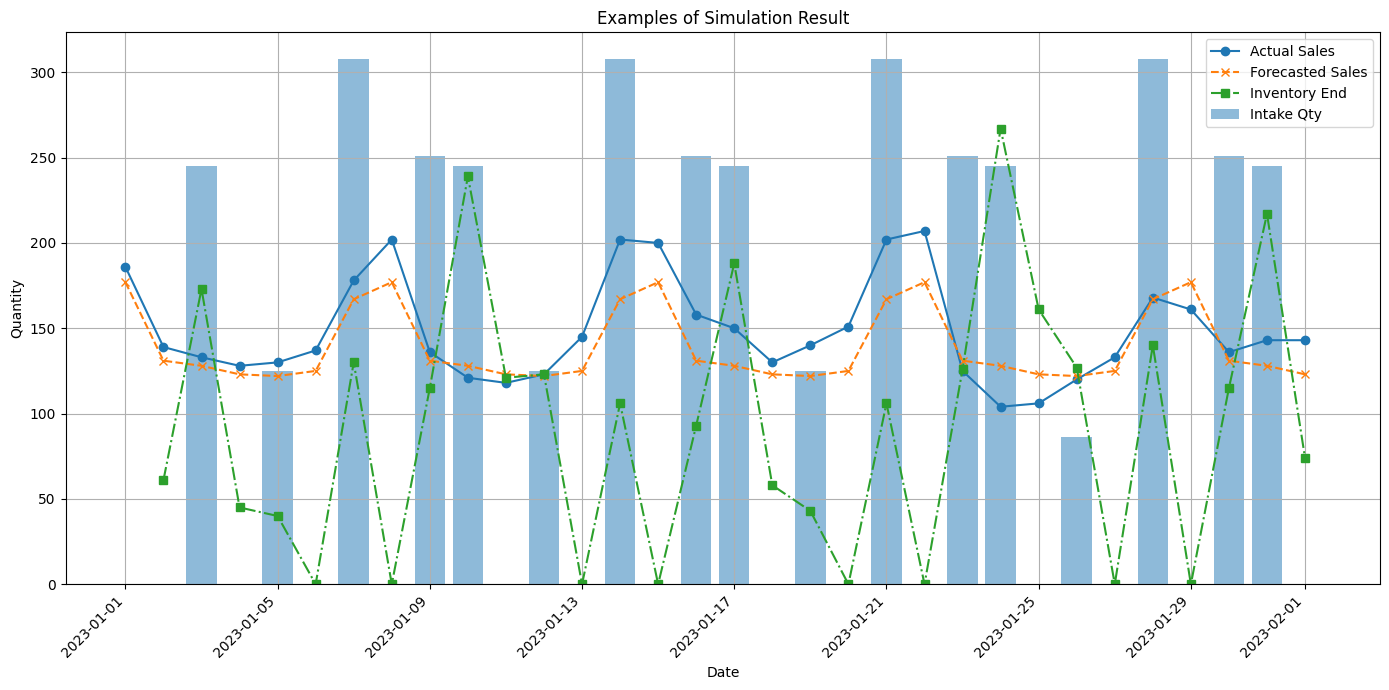

In [ ]:
# prompt: for df_a, plot the dynamics of actual sale, forecased salee, inventroy _end, and intake qty . plot intake qty using bars. for the others, use lines. one month of plot is enought

import matplotlib.pyplot as plt

# Assuming df_a is already defined as in your provided code

# Select the first month's data
first_month_data = df_a[df_a['Date'] <= df_a['Date'].min() + pd.DateOffset(months=1)]

# Plotting
plt.figure(figsize=(14, 7))

# Plot Actual Sales, Forecasted Sales, and Inventory End as lines
plt.plot(first_month_data['Date'], first_month_data['Actual_Sales'], label='Actual Sales', marker='o', linestyle='-')
plt.plot(first_month_data['Date'], first_month_data['Forecasted_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
plt.plot(first_month_data['Date'], first_month_data['Inventory_End'], label='Inventory End', marker='s', linestyle='-.')


# Plot Intake Quantity as bars
plt.bar(first_month_data['Date'], first_month_data['Intake_Qty'], label='Intake Qty', alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Examples of Simulation Result')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(True)
plt.show()


In [ ]:
final_time_series_df

,Order Pattern,Date,Day of Week,Actual_Sales,Forecasted_Sales,Inventory_End,Order_Qty,Intake_Qty
0,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-01,6,186,177,NaN,245.0,NaN
1,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-02,0,139,131,61.0,NaN,0.0
2,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-03,1,133,128,173.0,NaN,245.0
3,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-04,2,128,123,45.0,125.0,0.0
4,"[(2, 1), (3, 2), (5, 2), (6, 2)]",2023-01-05,3,130,122,40.0,308.0,125.0
...,...,...,...,...,...,...,...,...
194995,"[(0, 1), (1, 3), (4, 2), (5, 2)]",2023-05-26,4,132,125,343.0,259.0,475.0
194996,"[(0, 1), (1, 3), (4, 2), (5, 2)]",2023-05-27,5,199,167,144.0,33.0,0.0
194997,"[(0, 1), (1, 3), (4, 2), (5, 2)]",2023-05-28,6,200,177,203.0,NaN,259.0
194998,"[(0, 1), (1, 3), (4, 2), (5, 2)]",2023-05-29,0,120,131,116.0,0.0,33.0


# visualization

In [ ]:
final_time_series_df['Order Pattern'] = final_time_series_df['Order Pattern'].apply(tuple)

final_df = final_time_series_df.groupby(['Order Pattern','Day of Week'])['Inventory_End'].apply(lambda x: (x==0).mean()).reset_index(name='OOS ratio')
final_df

,Order Pattern,Day of Week,OOS ratio
0,"((0, 1), (1, 1))",0,0.954545
1,"((0, 1), (1, 1))",1,0.772727
2,"((0, 1), (1, 1))",2,0.714286
3,"((0, 1), (1, 1))",3,1.000000
4,"((0, 1), (1, 1))",4,1.000000
...,...,...,...
9095,"((5, 1), (6, 3))",2,0.000000
9096,"((5, 1), (6, 3))",3,0.000000
9097,"((5, 1), (6, 3))",4,0.476190
9098,"((5, 1), (6, 3))",5,1.000000


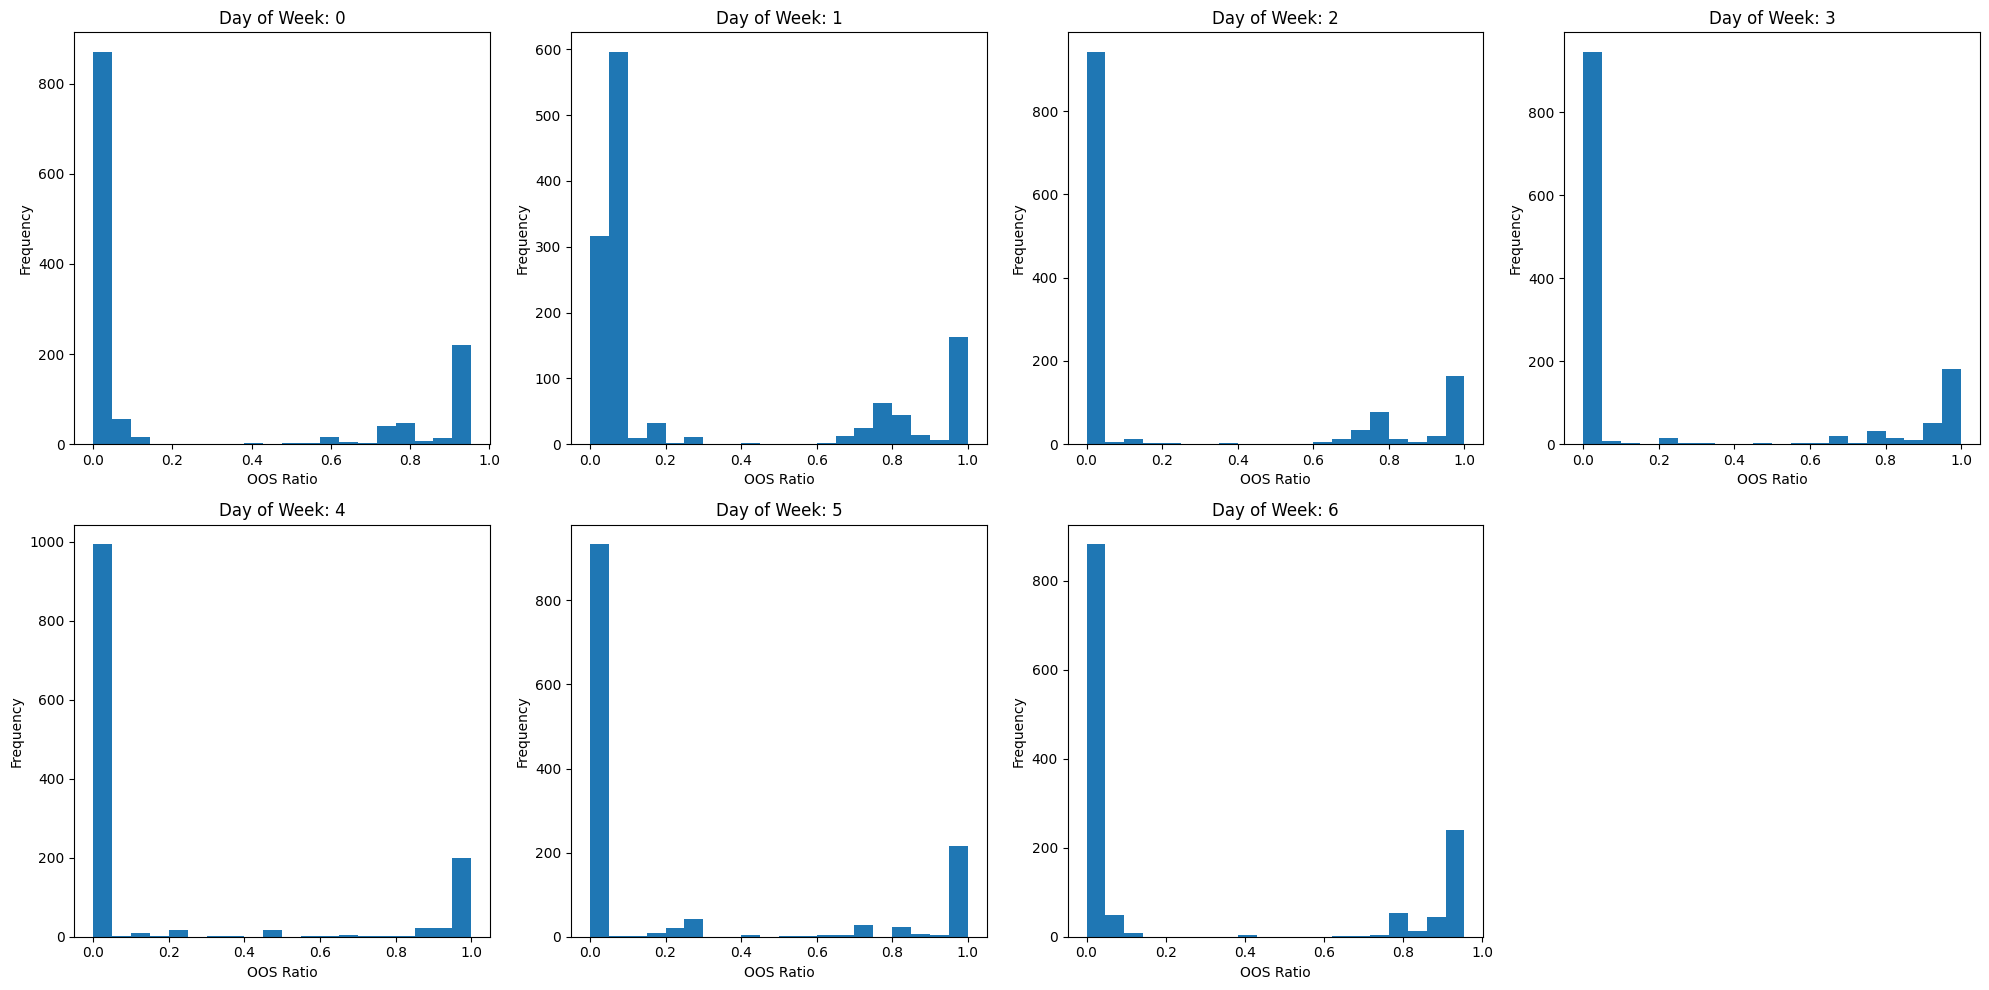

In [ ]:
# prompt: for final_df, plot the distribution of OOS ratio. each day of week is a subplot. subplots should be displayed as two rows, 4 and 3 graphs for each row. make sure you only have 7 plots in total.

import matplotlib.pyplot as plt

# Assuming final_df is already defined as in your provided code

# Create the subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

# Iterate through days of the week (0 to 6)
for i in range(7):
    # Calculate row and column index for the subplot
    row = i // 4
    col = i % 4

    # Filter the DataFrame for the current day of the week
    day_df = final_df[final_df['Day of Week'] == i]

    # Plot the distribution of OOS ratio for the current day
    axes[row, col].hist(day_df['OOS ratio'], bins= 20)  # Adjust the number of bins as needed
    axes[row, col].set_title(f'Day of Week: {i}')
    axes[row, col].set_xlabel('OOS Ratio')
    axes[row, col].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(7, 8):
    row = i // 4
    col = i % 4
    fig.delaxes(axes[row,col])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


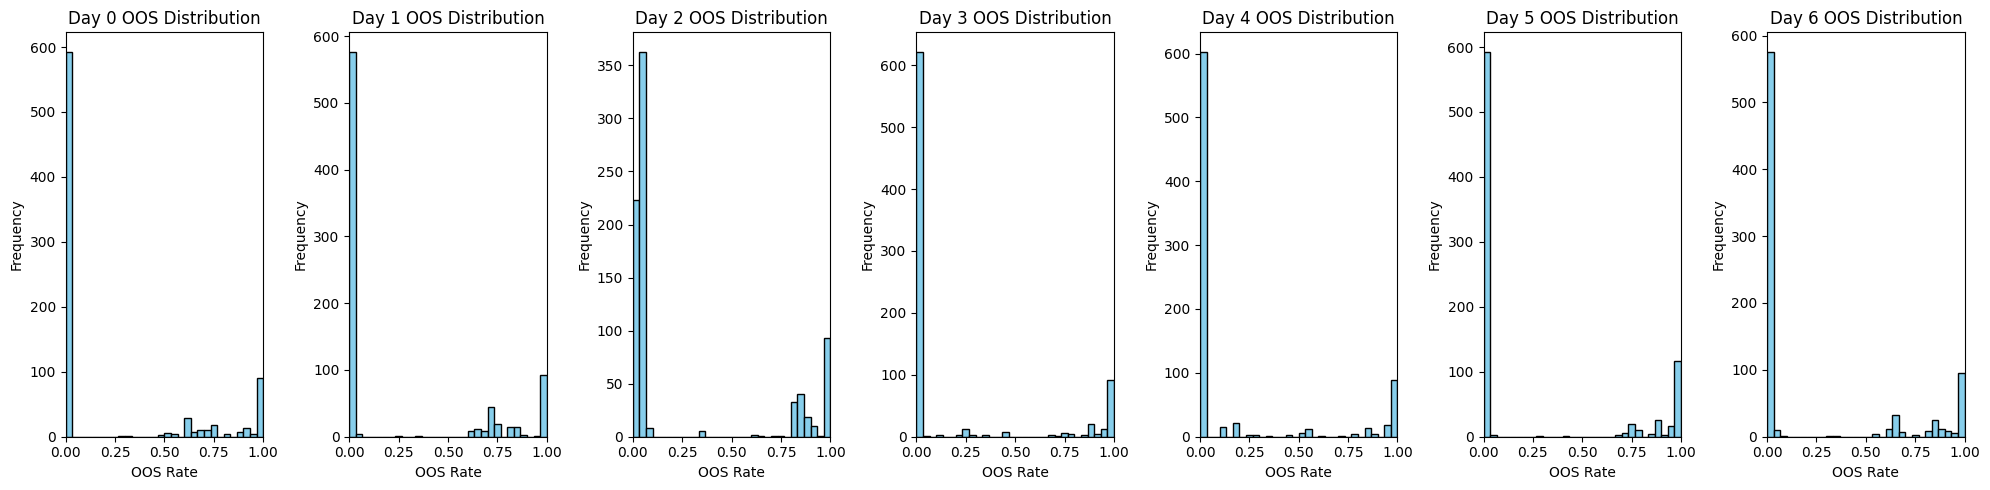

In [ ]:
import matplotlib.pyplot as plt

# Extract the OOS values from the training dataset
oos_train = y_train  # Assuming y_train contains the OOS values for training data (7 values per sample)

# Create subplots for each day of the week (7 days)
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Plot the distribution for each day of the week
for day in range(7):
    ax = axes[day]

    # Extract the OOS values for the specific day from the training dataset
    oos_day = oos_train[:, day]  # OOS values for this day across all samples

    # Plot the histogram for this day
    ax.hist(oos_day, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Day {day} OOS Distribution')
    ax.set_xlabel('OOS Rate')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 1)  # OOS rates are between 0 and 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# step 1: put the 1,0 and between. do the classfication?
# step 2: for the data between 0 and 1, do the regres

array([[0.03846154, 0.03846154, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03846154, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03846154, 0.03846154, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03846154, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30769231, 1.        , 1.        , ..., 0.04      , 0.        ,
        0.5       ],
       [0.03846154, 0.03846154, 0.03846154, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
comparison_df = pd.DataFrame({
   # 'Order Pattern': [str(inventory_simulation_results[i][0]) for i in range(len(y_test))],
   # 'Day of Week': [i % 7 for i in range(len(y_test))],  # Day of week corresponding to the test sample
    'Actual': y_test.flatten(),
    'Predicted': y_pred_final.flatten(),
      'y_pred_class': y_pred_class.flatten(),
    'y_pred_regression': y_pred_regression.flatten()
})

comparison_df

,Actual,Predicted,y_pred_class,y_pred_regression
0,0.560000,0.832109,1,0.832109
1,0.040000,0.923983,1,0.923983
2,0.040000,0.767996,1,0.767996
3,0.000000,0.547800,1,0.547800
4,0.000000,0.000000,0,0.172092
...,...,...,...,...
695,0.040000,0.000000,0,0.255226
696,0.791667,0.000000,0,0.320060
697,1.000000,0.000000,0,0.125103
698,0.000000,0.000000,0,0.114428


# New data structure

In [ ]:
comparison_df

,Order Pattern,Day of Week,Lead Time,Actual,Predicted
0,[0. 0. 1. 0. 1. 0. 1.],0,0.0,1,1
1,[0. 0. 1. 0. 1. 0. 1.],1,0.0,0,0
2,[0. 0. 1. 0. 1. 0. 1.],2,2.0,1,1
3,[0. 0. 1. 0. 1. 0. 1.],3,0.0,0,0
4,[0. 0. 1. 0. 1. 0. 1.],4,1.0,1,1
...,...,...,...,...,...
1045,[0. 1. 1. 1. 1. 0. 0.],2,0.0,0,0
1046,[0. 1. 1. 1. 1. 0. 0.],3,0.0,0,0
1047,[0. 1. 1. 1. 1. 0. 0.],4,3.0,0,0
1048,[0. 1. 1. 1. 1. 0. 0.],5,3.0,1,1


## Task 1: compare different input configuration,  will multiple runs

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')

activation = 'sigmoid'
loss = 'mean_squared_error'


def compute_wape_and_overprediction_ratio(y_true, y_pred, X_test):
    """
    Compute the WAPE (Weighted Absolute Percentage Error) and Overprediction Ratio for each day of the week.
    y_true: Actual OOS rates (true values)
    y_pred: Predicted OOS rates
    X_test: Input data to get the day of the week (from X_test[:, 14:])
    """
    # ?wape = []
    dist_from_balanced_pred = []
    wape_on_positive_oos = []
    mae_on_zero_oos = []

    for day in range(7):  # For each day of the week
        # Get the indices where the day of week matches the current day
        day_indices = np.where(X_test[:, 21 + day] == 1)[0]  # This gets the indices where day_of_week == day

        # Select the corresponding true and predicted values for that day
        actual_oos = y_true[day_indices]  # Actual OOS values for the current day
        predicted_oos = y_pred[day_indices]  # Predicted OOS values for the current day

        # Flatten the values to avoid dimension mismatches
        actual_oos = actual_oos.flatten()
        predicted_oos = predicted_oos.flatten()

        # WAPE Calculation
        positive_oos = actual_oos[actual_oos > 0]
        zero_oos = actual_oos[actual_oos == 0]

        pred_on_positive_oos = predicted_oos[actual_oos > 0]
        pred_on_zero_oos = predicted_oos[actual_oos == 0]

        wape_day_on_positive_oos = np.sum(np.abs(pred_on_positive_oos - positive_oos)) / np.sum(positive_oos)
        mae_day_on_zero_oos = np.sum(np.abs(pred_on_zero_oos )) / len(zero_oos)

        # abs_error = np.abs(predicted_oos - actual_oos)
        # numerator = np.sum(abs_error)
        # denominator = np.sum(np.abs(actual_oos))
        # wape_day = numerator / denominator if denominator != 0 else 0
        # wape.append(wape_day)
        wape_on_positive_oos.append(wape_day_on_positive_oos)
        mae_on_zero_oos.append(mae_day_on_zero_oos)

        # Overprediction Ratio Calculation
        overpredictions = np.sum(predicted_oos > actual_oos)
        overprediction_ratio_day = overpredictions / len(actual_oos) if len(actual_oos) > 0 else 0
        dist_from_balanced_pred.append(abs(overprediction_ratio_day-0.5))

    return np.array(wape_on_positive_oos).mean(), np.array(mae_on_zero_oos).mean()#np.array(dist_from_balanced_pred).mean()


# Prepare the final training data
order_day_data = []  # Store the order day data
lead_time_data = []  # Store the lead time data
arrival_day_data = []  # Store the computed arrival day data
day_of_week_data = []  # Store the day of week data
oos_data = []  # Store the actual OOS data

# For each sample in inventory_simulation_results, generate rows for all days of the week
for sample in inventory_simulation_results:
    order_day_vec = sample[0]  # One-hot encoded order day
    lead_time_vec = sample[1]  # Lead times for each day (7 values)

    arrival_day_info = [(i + lead_time_vec[i]) % 7 if order_day_vec[i] == 1 else np.nan for i in range(7)]

    arrival_day_vec = [1 if i in arrival_day_info else 0 for i in range(7)]
    oos_rates = sample[2]  # OOS rates for each of the 7 days

    for day in range(7):
        # One-hot encoding for day of the week (i.e., 1 for the current day, 0 for others)
        day_of_week_vec = [1 if i == day else 0 for i in range(7)]

        order_day_data.append(order_day_vec)
        lead_time_data.append(lead_time_vec)
        arrival_day_data.append(arrival_day_vec)
        day_of_week_data.append(day_of_week_vec)
        oos_data.append(oos_rates[day])

# Convert to numpy arrays
order_day_data = np.array(order_day_data)
lead_time_data = np.array(lead_time_data)
arrival_day_data = np.array(arrival_day_data)
day_of_week_data = np.array(day_of_week_data)
oos_data = np.array(oos_data)

# Function to build model
def build_model(input_format):
    inputs = []

    for input_data in input_format:
        input_layer = layers.Input(shape=(input_data.shape[1],))  # Shape of input_data
        inputs.append(input_layer)

    # Concatenate all input layers
    x = layers.Concatenate()(inputs)

    # Add hidden layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    output = layers.Dense(1, activation= activation)(x)  # Output layer for OOS prediction
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss= loss) # 'mean_squared_error'
    return model


# 2. Split data into train, validate, and test
X_data = np.concatenate([order_day_data, lead_time_data, arrival_day_data, day_of_week_data], axis=1)  # Concatenate order_day, lead_time, day_of_week
# Initialize a list to store results
results = []

# Initialize tracking for early stopping
patience = 20
no_improvement_count = 0
best_val_loss = np.inf  # Initialize with a high value

# Function to train the model
def train_model(i, input_format, val_data, test_data):
    global best_val_loss, no_improvement_count

    # Rebuild model for each iteration
    model = build_model(input_format)  # Create a fresh model
    print(f"Training Model {i}")

    for epoch in range(30):
        history = model.fit(input_format, y_train, epochs=1, batch_size=32, validation_data=(val_data, y_val))
        val_loss = history.history['val_loss'][0]

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stopping if no improvement in validation loss for 'patience' epochs
        if no_improvement_count >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Restarting training.")
            return False, None,None  # Indicate that we should restart training

    # After training or early stopping, make predictions on the test data
    y_pred_regression = model.predict(test_data)

    # Compute WAPE and Overprediction Ratio for the test set
    avg_wape_on_positive_oos, avg_mae_on_zero_oos = compute_wape_and_overprediction_ratio(y_test, y_pred_regression, X_test)

    return True, avg_wape_on_positive_oos, avg_mae_on_zero_oos  # Return the results for the current model

# Train and evaluate the model with different inputs multiple times

for loop_num in range(10):  # Run each model 5 times
    print(f"Loop {loop_num}")
    # Split data inside the loop to ensure fresh data splits for each training run
    X_train, X_temp, y_train, y_temp = train_test_split(X_data, oos_data, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
    for model_id in [ 0,1,2, 3,4,5]:

        if model_id == 0:
            input_format = [X_train[:, :7], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 1:
            input_format = [X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 2:
            input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 21:]]
        elif model_id ==3 :
            input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 4:
            input_format = [X_train[:, 14:21], X_train[:, 21:]]
            val_data = [X_val[:, 14:21],  X_val[:, 21:]]
            test_data = [X_test[:, 14:21],  X_test[:, 21:]]
        else:
            input_format = [ X_train[:, 7:14], X_train[:, 21:]]
            val_data = [ X_val[:, 7:14], X_val[:, 21:]]
            test_data = [ X_test[:, 7:14], X_test[:, 21:]]

        # Keep retraining the model until we get valid results
        while True:
            # Reset best_val_loss and no_improvement_count when restarting training
            best_val_loss = np.inf  # Reset the best validation loss when model is rebuilt
            no_improvement_count = 0  # Reset counter

            success_flg, avg_wape_on_positive_oos, avg_mae_on_zero_oos= train_model(model_id, input_format, val_data, test_data)
            if avg_wape_on_positive_oos is not None:
                # Collect results for each loop and model
                #for day in range(7):
                results.append([loop_num, model_id, avg_wape_on_positive_oos, avg_mae_on_zero_oos])
                break  # Exit loop if training was successful

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Loop Num", "Model Num", "avg_wape_on_positive_oos", "avg_mae_on_zero_oos"])


import datetime
# Save the DataFrame to a CSV file in your Google Drive
results_df.to_excel(f'/content/drive/MyDrive/order_pattern_feature_training_{activation}_{loss}_{sample_size}_{datetime.datetime.now()}.xlsx', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loop 0
Training Model 0
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1313 - val_loss: 0.1186
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1028 - val_loss: 0.1192
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0969 - val_loss: 0.1159
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0941 - val_loss: 0.1088
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0876 - val_loss: 0.1041
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0817 - val_loss: 0.0986
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0765 - val_loss: 0.0953
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0694 - val_loss: 0.0911
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0647 - val_loss: 0.0877
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0569 - val_loss: 0.0906
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0578 - val_loss: 0.0772
228/228 ━━━━━━━━━━━━━━

NameError: name 'datetime' is not defined

### Visualization

   Loop Num  Model Num  avg_wape_on_positive_oos  avg_mae_on_zero_oos
0         0          0                  0.272210             0.037277
1         0          1                  0.209712             0.007078
2         0          2                  0.429945             0.048957
3         0          3                  0.199519             0.013465
4         0          4                  0.615598             0.091766


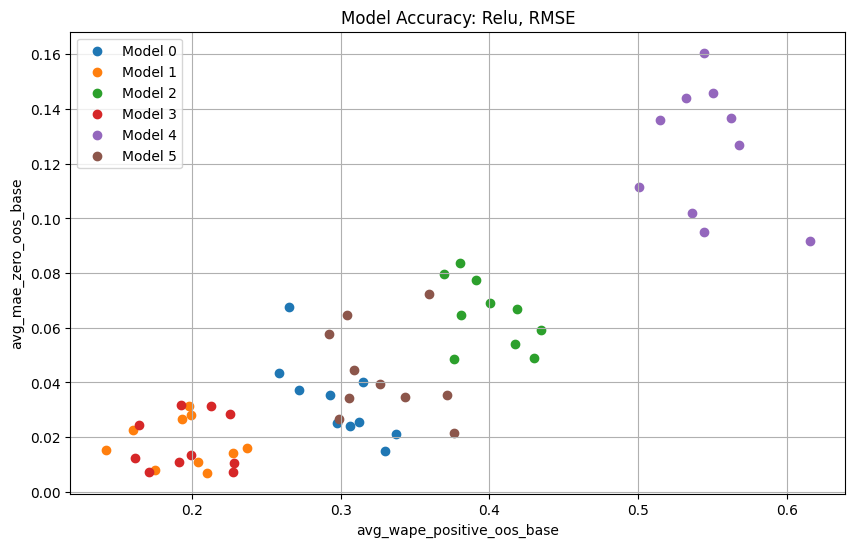

In [ ]:
# prompt: read excel table order_pattern_feature_training_relu_mean_squared_error_1300 from my drive
import pandas as pd


file_path = '/content/drive/MyDrive/order_pattern_feature_training_relu_mean_squared_error_1300_2025-04-18 01:26:29.917287.xlsx'

# order_pattern_feature_training_relu_mean_squared_error_1300_2025-04-18 01:26:29.917287
# order_pattern_feature_training_sigmoid_mean_squared_error_1300_2025-04-18 14:27:40.036641
try:
  df = pd.read_excel(file_path)
  print(df.head()) # Print first few rows for verification
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

# prompt: for df,  plot scatter plot of avg_wape and avg_dist_from_balanced_pred. each model num represents a color

import matplotlib.pyplot as plt

# Assuming 'df' is already loaded from the Excel file as shown in the previous code

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for model_num in df['Model Num'].unique():
    subset = df[df['Model Num'] == model_num]
    # "avg_ape_on_positive_oos", "avg_ape_on_zero_oos"
    plt.scatter(subset['avg_wape_on_positive_oos'], subset['avg_mae_on_zero_oos'], label=f'Model {model_num}')

plt.ylabel('avg_mae_zero_oos_base')
plt.xlabel('avg_wape_positive_oos_base')
plt.title('Model Accuracy: Relu, RMSE')
plt.legend()
plt.grid(True)
plt.show()

## Task 2: compare relu and sigmoid

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')

#activation = 'relu'
loss = 'mean_squared_error'



def compute_wape_and_overprediction_ratio(y_true, y_pred, X_test):
    """
    Compute the WAPE (Weighted Absolute Percentage Error) and Overprediction Ratio for each day of the week.
    y_true: Actual OOS rates (true values)
    y_pred: Predicted OOS rates
    X_test: Input data to get the day of the week (from X_test[:, 14:])
    """
    # ?wape = []
    dist_from_balanced_pred = []
    wape_on_positive_oos = []
    mae_on_zero_oos = []
    overpred_on_positive_oos = []

    for day in range(7):  # For each day of the week
        # Get the indices where the day of week matches the current day
        day_indices = np.where(X_test[:, 21 + day] == 1)[0]  # This gets the indices where day_of_week == day

        # Select the corresponding true and predicted values for that day
        actual_oos = y_true[day_indices]  # Actual OOS values for the current day
        predicted_oos = y_pred[day_indices]  # Predicted OOS values for the current day

        # Flatten the values to avoid dimension mismatches
        actual_oos = actual_oos.flatten()
        predicted_oos = predicted_oos.flatten()

        # WAPE Calculation
        positive_oos = actual_oos[actual_oos > 0]
        zero_oos = actual_oos[actual_oos == 0]

        pred_on_positive_oos = predicted_oos[actual_oos > 0]
        pred_on_zero_oos = predicted_oos[actual_oos == 0]

        wape_day_on_positive_oos = np.sum(np.abs(pred_on_positive_oos - positive_oos)) / np.sum(positive_oos)
        mae_day_on_zero_oos = np.sum(np.abs(pred_on_zero_oos )) / len(zero_oos)

        # abs_error = np.abs(predicted_oos - actual_oos)
        # numerator = np.sum(abs_error)
        # denominator = np.sum(np.abs(actual_oos))
        # wape_day = numerator / denominator if denominator != 0 else 0
        # wape.append(wape_day)
        wape_on_positive_oos.append(wape_day_on_positive_oos)
        mae_on_zero_oos.append(mae_day_on_zero_oos)

        # Overprediction Ratio Calculation
        overpred_day_on_positive_oos = np.sum(pred_on_positive_oos > positive_oos)/len(positive_oos)
        # overprediction_ratio_day = overpred_on_positive_oos / len(positive_oos)
        overpred_on_positive_oos.append(overpred_day_on_positive_oos)

    return np.array(wape_on_positive_oos).mean(), np.array(mae_on_zero_oos).mean(), np.array(overpred_on_positive_oos).mean()


# Prepare the final training data
order_day_data = []  # Store the order day data
lead_time_data = []  # Store the lead time data
arrival_day_data = []  # Store the computed arrival day data
day_of_week_data = []  # Store the day of week data
oos_data = []  # Store the actual OOS data

# For each sample in inventory_simulation_results, generate rows for all days of the week
for sample in inventory_simulation_results:
    order_day_vec = sample[0]  # One-hot encoded order day
    lead_time_vec = sample[1]  # Lead times for each day (7 values)

    arrival_day_info = [(i + lead_time_vec[i]) % 7 if order_day_vec[i] == 1 else np.nan for i in range(7)]

    arrival_day_vec = [1 if i in arrival_day_info else 0 for i in range(7)]
    oos_rates = sample[2]  # OOS rates for each of the 7 days

    for day in range(7):
        # One-hot encoding for day of the week (i.e., 1 for the current day, 0 for others)
        day_of_week_vec = [1 if i == day else 0 for i in range(7)]

        order_day_data.append(order_day_vec)
        lead_time_data.append(lead_time_vec)
        arrival_day_data.append(arrival_day_vec)
        day_of_week_data.append(day_of_week_vec)
        oos_data.append(oos_rates[day])

# Convert to numpy arrays
order_day_data = np.array(order_day_data)
lead_time_data = np.array(lead_time_data)
arrival_day_data = np.array(arrival_day_data)
day_of_week_data = np.array(day_of_week_data)
oos_data = np.array(oos_data)

# Function to build model
def build_model(input_format, activation):
    inputs = []

    for input_data in input_format:
        input_layer = layers.Input(shape=(input_data.shape[1],))  # Shape of input_data
        inputs.append(input_layer)

    # Concatenate all input layers
    x = layers.Concatenate()(inputs)

    # Add hidden layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    output = layers.Dense(1, activation= activation)(x)  # Output layer for OOS prediction
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss= loss) # 'mean_squared_error'
    return model


# 2. Split data into train, validate, and test
X_data = np.concatenate([order_day_data, lead_time_data, arrival_day_data, day_of_week_data], axis=1)  # Concatenate order_day, lead_time, day_of_week
# Initialize a list to store results
results = []

# Initialize tracking for early stopping
patience = 20
no_improvement_count = 0
best_val_loss = np.inf  # Initialize with a high value

# Function to train the model
def train_model(i, input_format, val_data, test_data,activation):
    global best_val_loss, no_improvement_count

    # Rebuild model for each iteration
    model = build_model(input_format, activation)  # Create a fresh model
    print(f"Training Model {i}")

    for epoch in range(30):
        history = model.fit(input_format, y_train, epochs=1, batch_size=32, validation_data=(val_data, y_val))
        val_loss = history.history['val_loss'][0]

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stopping if no improvement in validation loss for 'patience' epochs
        if no_improvement_count >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Restarting training.")
            return False, None,None, None  # Indicate that we should restart training

    # After training or early stopping, make predictions on the test data
    y_pred_regression = model.predict(test_data)

    # Compute WAPE and Overprediction Ratio for the test set
    avg_wape_on_positive_oos, avg_mae_on_zero_oos, overpred_on_positive_oos = compute_wape_and_overprediction_ratio(y_test, y_pred_regression, X_test)

    return True, avg_wape_on_positive_oos, avg_mae_on_zero_oos,overpred_on_positive_oos  # Return the results for the current model

# Train and evaluate the model with different inputs multiple times

model_id = 3



for loop_num in range(20):  # Run each model 5 times
    print(f"Loop {loop_num}")
    # Split data inside the loop to ensure fresh data splits for each training run
    X_train, X_temp, y_train, y_temp = train_test_split(X_data, oos_data, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
    for activation in [ 'relu','sigmoid']:

        if model_id == 0:
            input_format = [X_train[:, :7], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 1:
            input_format = [X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 2:
            input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 21:]]
        elif model_id ==3 :
            input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
            val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
            test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
        elif model_id == 4:
            input_format = [X_train[:, 14:21], X_train[:, 21:]]
            val_data = [X_val[:, 14:21],  X_val[:, 21:]]
            test_data = [X_test[:, 14:21],  X_test[:, 21:]]
        else:
            input_format = [ X_train[:, 7:14], X_train[:, 21:]]
            val_data = [ X_val[:, 7:14], X_val[:, 21:]]
            test_data = [ X_test[:, 7:14], X_test[:, 21:]]

        # Keep retraining the model until we get valid results
        while True:
            # Reset best_val_loss and no_improvement_count when restarting training
            best_val_loss = np.inf  # Reset the best validation loss when model is rebuilt
            no_improvement_count = 0  # Reset counter

            success_flg, avg_wape_on_positive_oos, avg_mae_on_zero_oos, overpred_on_positive_oos= train_model(model_id, input_format, val_data, test_data,activation)
            if  avg_wape_on_positive_oos is not None:
                # Collect results for each loop and model
                #for day in range(7):
                results.append([loop_num, activation, avg_wape_on_positive_oos, avg_mae_on_zero_oos, overpred_on_positive_oos])
                break  # Exit loop if training was successful

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Loop Num", "Activation", "avg_wape_on_positive_oos", "avg_mae_on_zero_oos","overpred_on_positive_oos"])



# Save the DataFrame to a CSV file in your Google Drive
results_df.to_excel(f'/content/drive/MyDrive/order_pattern_activation_trainin_{loss}_{sample_size}_{datetime.datetime.now()}.xlsx', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loop 0
Training Model 3
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1959 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1905 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1956 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1970 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2016 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1952 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2020 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2012 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1976 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1971 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1932 - val_loss: 0.2030
228/228 ━━━━━━━━━━━━━━

### Visualization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


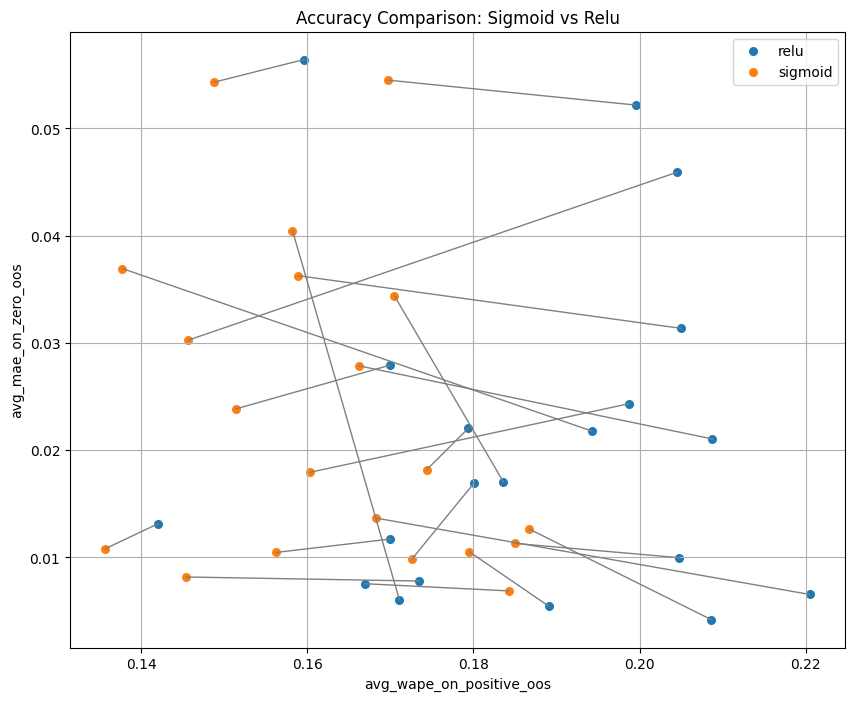

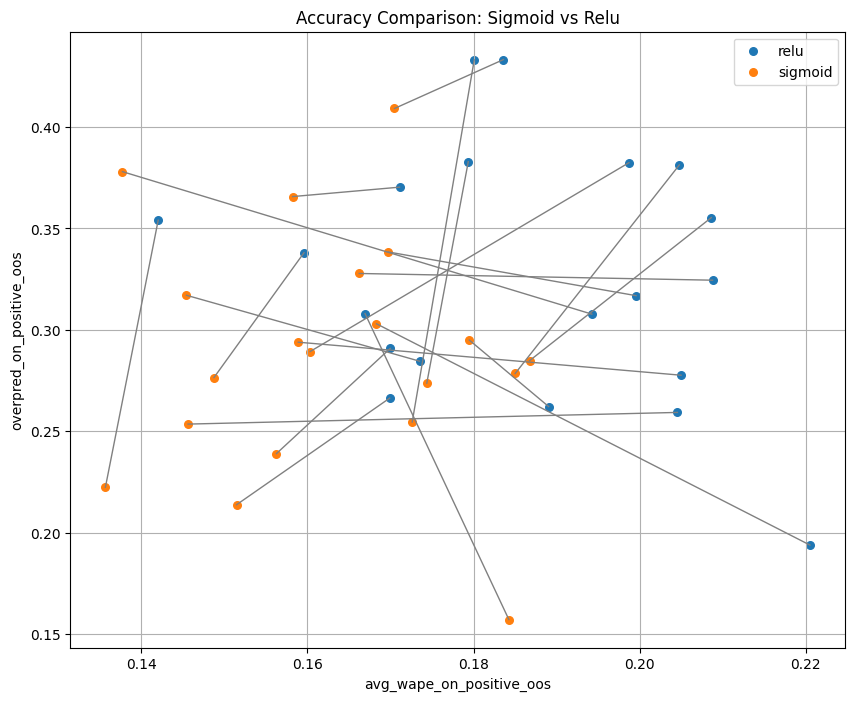

In [ ]:
# prompt: read excel table order_pattern_feature_training_relu_mean_squared_error_1300 from my drive
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/order_pattern_activation_trainin_mean_squared_error_1300_2025-04-18 14:58:38.255461.xlsx'

df = pd.read_excel(file_path)


# prompt: for df,  plot scatter plot of avg_wape and avg_dist_from_balanced_pred. each model num represents a color

import matplotlib.pyplot as plt

# Assuming 'df' is already loaded from the Excel file as shown in the previous code


# Create the scatter plot
plt.figure(figsize=(10, 8))
for activation in df['Activation'].unique():
    subset = df[df['Activation'] == activation]
    plt.scatter(subset['avg_wape_on_positive_oos'], subset['avg_mae_on_zero_oos'], label=activation, s=30) # Increased marker size
    # Connect points with the same loop number

for loop_num in df['Loop Num'].unique():
    loop_subset = df[df['Loop Num'] == loop_num]
    plt.plot(loop_subset['avg_wape_on_positive_oos'], loop_subset['avg_mae_on_zero_oos'], linestyle='-', linewidth=1, color='gray')


plt.ylabel('avg_mae_on_zero_oos')
plt.xlabel('avg_wape_on_positive_oos')
plt.title('Accuracy Comparison: Sigmoid vs Relu')
plt.legend()
plt.grid(True)
plt.show()


##########

plt.figure(figsize=(10, 8))
for activation in df['Activation'].unique():
    subset = df[df['Activation'] == activation]
    plt.scatter(subset['avg_wape_on_positive_oos'], subset['overpred_on_positive_oos'], label=activation, s=30) # Increased marker size
    # Connect points with the same loop number

for loop_num in df['Loop Num'].unique():
    loop_subset = df[df['Loop Num'] == loop_num]
    plt.plot(loop_subset['avg_wape_on_positive_oos'], loop_subset['overpred_on_positive_oos'], linestyle='-', linewidth=1, color='gray')


plt.ylabel('overpred_on_positive_oos')
plt.xlabel('avg_wape_on_positive_oos')
plt.title('Accuracy Comparison: Sigmoid vs Relu')
plt.legend()
plt.grid(True)
plt.show()



## Task 3:  two-step Approach

### first, find the best threshold and weight


In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 781.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report, roc_auc_score

#random_state = 42

from google.colab import drive
drive.mount('/content/drive')

i = 3
j = 3

reg_activation = 'relu'
reg_loss = 'mean_squared_error'




# 1. Prepare the final training data (same as before)
order_day_data = []
lead_time_data = []
arrival_day_data = []
day_of_week_data = []
oos_data = []


def compute_wape_and_overprediction_ratio(y_true, y_pred, X_test):
    """
    Compute the WAPE (Weighted Absolute Percentage Error) and Overprediction Ratio for each day of the week.
    y_true: Actual OOS rates (true values)
    y_pred: Predicted OOS rates
    X_test: Input data to get the day of the week (from X_test[:, 14:])
    """
    # ?wape = []
    dist_from_balanced_pred = []
    ape_on_positive_oos = []
    wape_on_positive_oos = []
    mae_on_zero_oos = []

    for day in range(7):  # For each day of the week
        # Get the indices where the day of week matches the current day
        day_indices = np.where(X_test[:, 21 + day] == 1)[0]  # This gets the indices where day_of_week == day

        # Select the corresponding true and predicted values for that day
        actual_oos = y_true[day_indices]  # Actual OOS values for the current day
        predicted_oos = y_pred[day_indices]  # Predicted OOS values for the current day

        # Flatten the values to avoid dimension mismatches
        actual_oos = actual_oos.flatten()
        predicted_oos = predicted_oos.flatten()

        # WAPE Calculation
        positive_oos = actual_oos[actual_oos > 0]
        zero_oos = actual_oos[actual_oos == 0]

        pred_on_positive_oos = predicted_oos[actual_oos > 0]
        pred_on_zero_oos = predicted_oos[actual_oos == 0]

        wape_day_on_positive_oos = np.sum(np.abs(pred_on_positive_oos - positive_oos)) / np.sum(positive_oos)  #np.sum(positive_oos)
        ape_day_on_positive_oos = np.sum(np.abs(pred_on_positive_oos - positive_oos)) / len(positive_oos)  #np.sum(positive_oos)

        mae_day_on_zero_oos = np.sum(np.abs(pred_on_zero_oos )) / len(zero_oos)

        # abs_error = np.abs(predicted_oos - actual_oos)
        # numerator = np.sum(abs_error)
        # denominator = np.sum(np.abs(actual_oos))
        # wape_day = numerator / denominator if denominator != 0 else 0
        # wape.append(wape_day)
        ape_on_positive_oos.append(ape_day_on_positive_oos)
        wape_on_positive_oos.append(wape_day_on_positive_oos)
        mae_on_zero_oos.append(mae_day_on_zero_oos)


        # Overprediction Ratio Calculation
        overpredictions = np.sum(predicted_oos > actual_oos)
        overprediction_ratio_day = overpredictions / len(actual_oos) if len(actual_oos) > 0 else 0
        dist_from_balanced_pred.append(abs(overprediction_ratio_day-0.5))

    return  np.array(wape_on_positive_oos).mean(),np.array(mae_on_zero_oos).mean(),#np.array(dist_from_balanced_pred).mean()


# def masked_rmse_loss(y_true, y_pred):
#     """
#     Compute RMSE (Root Mean Squared Error) loss, ignoring where y_true is 0.
#     """
#     mask = K.cast(K.greater(y_true, 0), K.floatx())  # Mask is 1 when y_true > 0, else 0
#     squared_error = K.square(y_true - y_pred)
#     masked_squared_error = squared_error * mask
#     rmse = K.sqrt(K.sum(masked_squared_error) / K.sum(mask))  # Normalize by number of non-zero values
#     return rmse

# def masked_mae_loss(y_true, y_pred):
#     """
#     Compute RMSE (Root Mean Squared Error) loss, ignoring where y_true is 0.
#     """
#     mask = K.cast(K.greater(y_true, 0), K.floatx())  # Mask is 1 when y_true > 0, else 0
#     squared_error = K.abs(y_true - y_pred)
#     masked_squared_error = squared_error * mask
#     rmse = K.sqrt(K.sum(masked_squared_error) / K.sum(mask))  # Normalize by number of non-zero values
#     return rmse

# For each sample in inventory_simulation_results, generate rows for all days of the week
for sample in inventory_simulation_results:
    order_day_vec = sample[0]  # One-hot encoded order day
    lead_time_vec = sample[1]  # Lead times for each day (7 values)

    arrival_day_info = [(i + lead_time_vec[i] ) % 7 if order_day_vec[i]==1 else np.nan for i in range(7)]

    arrival_day_vec = [ 1 if i in arrival_day_info else 0 for i in range(7) ]

    oos_rates = sample[2]  # OOS rates for each of the 7 days

    # For each day of the week (0 to 6)
    for day in range(7):
        # One-hot encoding for order day (i.e., 1 for the order day, 0 for others)
        #order_day_vec = [1 if i == day else 0 for i in range(7)]

        # One-hot encoding for arrival day (i.e., 1 for the arrival day, 0 for others)
        #arrive_day_vec = [1 if i == arrival_day_vec[day] else 0 for i in range(7)]

        # One-hot encoding for day of the week (i.e., 1 for the current day, 0 for others)
        day_of_week_vec = [1 if i == day else 0 for i in range(7)]

        # Append the data
        order_day_data.append(order_day_vec)
        lead_time_data.append(lead_time_vec)
        arrival_day_data.append(arrival_day_vec)
        day_of_week_data.append(day_of_week_vec)
        oos_data.append(oos_rates[day])  # The OOS rate corresponding to the current day

# Convert to numpy arrays
order_day_data = np.array(order_day_data)
lead_time_data = np.array(lead_time_data)
arrival_day_data = np.array(arrival_day_data)
day_of_week_data = np.array(day_of_week_data)
oos_data = np.array(oos_data)

# 2. Split data into train, validate, and test
X_data = np.concatenate([order_day_data, lead_time_data, arrival_day_data, day_of_week_data], axis=1)  # Concatenate order_day, lead_time, day_of_week


# 2. Split data into train, validate, and test
#X_data = np.concatenate([order_day_data, lead_time_data, day_of_week_data], axis=1)  # Concatenate order_day, lead_time, day_of_week

# run multiple times. find the best one.

df_res_wape_positive_oos = []
df_res_mae_zero_oos = []

X_train_val, X_test, y_train_val, y_test = train_test_split(
      X_data, oos_data, test_size=0.1 # , random_state=random_state
  )


for iter in range(10):

  print('iter:', iter)



  # Split data into train/validation/test sets
  # X_train, X_temp, y_train, y_temp = train_test_split(
  #     X_data, oos_data, test_size=0.2 # , random_state=random_state
  # )
  # X_val, X_test, y_val, y_test = train_test_split(
  #     X_temp, y_temp, test_size=0.5 #, random_state= random_state
  # )

  X_train, X_val, y_train, y_val = train_test_split(
      X_train_val, y_train_val, test_size=1/9 #, random_state= random_state
  )

  # 3. Train Classification Model
  # Transform y_train and y_val to a 2D array where each row corresponds to 7 days (for classification)
  y_train_class = (y_train > 0).astype(int)  # Binary classification for OOS (1 for non-zero OOS, else 0)
  y_val_class = (y_val > 0).astype(int)  # Similarly for validation set

  # --- Classification Model Setup ---
  # order_day_input = layers.Input(shape=(7,))  # One-hot encoding for 7 order days
  # lead_time_input = layers.Input(shape=(7,))  # Lead times as raw integers (7 values, one for each day)
  # day_of_week_input = layers.Input(shape=(7,))  # One-hot encoded day of week input

  # Train the classification model


  if i == 0:
      input_format = [X_train[:, :7], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, :7], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, :7], X_test[:, 7:14], X_test[:, 21:]]
  elif i == 1:
      input_format = [X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
  elif i == 2:
      input_format = [X_train[:, :7],X_train[:, 14:21], X_train[:, 21:]]
      val_data = [X_val[:, :7],X_val[:, 14:21], X_val[:, 21:]]
      test_data = [X_test[:, :7],X_test[:, 14:21], X_test[:, 21:]]
  else:
      input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]

  inputs = []
  for input_data in input_format:
      input_layer = layers.Input(shape=(input_data.shape[1],))  # Shape of input_data
      inputs.append(input_layer)

  # Concatenate the inputs
  #x = layers.Concatenate()([order_day_input, lead_time_input, day_of_week_input])
  x = layers.Concatenate()(inputs)

  # Add hidden layers
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(32, activation='relu')(x)

  # Output layer for OOS prediction (7 outputs, one for each day of the week)
  output = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification (0 or 1)

  # Define the model
  classification_model = models.Model(inputs= inputs, outputs=output)
  #classification_model = models.Model(inputs=[order_day_input, lead_time_input, day_of_week_input], outputs=output)

  # Compile the model with binary cross-entropy loss (for multi-label binary classification)
  classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #classification_model.fit([X_train[:, :7], X_train[:, 7:14], X_train[:, 14:]], y_train_class, epochs= 30, batch_size=32, validation_data=([X_val[:, :7], X_val[:, 7:14], X_val[:, 14:]], y_val_class))

  #y_pred_class_prob = classification_model.predict([X_test[:, :7], X_test[:, 7:14], X_test[:, 14:]])  # Predicted probabilities (values between 0 and 1)

  classification_model.fit(input_format, y_train_class, epochs= 30, batch_size=32, validation_data=(val_data, y_val_class), verbose=0)

  y_pred_class_prob = classification_model.predict(val_data)  # Predicted probabilities (values between 0 and 1)


  # --- Regression Model Setup ---
  # Define regression model for OOS values (scaler output)

  # Train the classification model

  if j == 0:
      input_format = [X_train[:, :7], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, :7], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, :7], X_test[:, 7:14], X_test[:, 21:]]
  elif j == 1:
      input_format = [X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
  elif j == 2:
      input_format = [X_train[:, :7],X_train[:, 14:21], X_train[:, 21:]]
      val_data = [X_val[:, :7],X_val[:, 14:21], X_val[:, 21:]]
      test_data = [X_test[:, :7],X_test[:, 14:21], X_test[:, 21:]]
  else:
      input_format = [X_train[:, :7], X_train[:, 14:21], X_train[:, 7:14], X_train[:, 21:]]
      val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
      test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]

  inputs = []
  for input_data in input_format:
      input_layer = layers.Input(shape=(input_data.shape[1],))  # Shape of input_data
      inputs.append(input_layer)
  # Define the regression model
  #regression_model = models.Model(inputs= inputs, outputs=output_regression)
  #regression_model = models.Model(inputs=[order_day_input, lead_time_input, day_of_week_input], outputs=output_regression)



  # Compile the regression model with masked RMSE loss

  avg_wape_positive_oos_best = 1000
  avg_mae_zero_oos_best = 1000
  best_threshold = None
  best_zero_value_weight = None

  ######## now, we want to find the best combination of zero_value_weigh and threshold on validate data.

  for zero_value_weight in [k*0.05 for k in range(21)]: # [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
    print('zero value sample weights', zero_value_weight)
    sample_weights = np.where(y_train > 0, 1.0, zero_value_weight)
    # Train the regression model

    patience = 10

    cont_flg = True
    while cont_flg == True:
      x = layers.Concatenate()(inputs)
  # Add hidden layers
      x = layers.Dense(128, activation='relu')(x)
      x = layers.Dense(64, activation='relu')(x)
      x = layers.Dense(32, activation='relu')(x)
      output_regression = layers.Dense(1, activation= reg_activation)(x)  # ReLU for regression model
      #regression_model.fit([X_train[:, :7], X_train[:, 7:14], X_train[:, 14:]], y_train, epochs= 30, batch_size=32, sample_weight=sample_weights,validation_data=([X_val[:, :7], X_val[:, 7:14], X_val[:, 14:]], y_val))
      regression_model = models.Model(inputs= inputs, outputs=output_regression)
      regression_model.compile(optimizer='adam', loss= reg_loss )   #masked_rmse_loss

      no_improvement_count = 0
      best_val_loss = float('inf')
      fail_flg = False
      for epoch in range(25):
          history = regression_model.fit(input_format, y_train, epochs=1, batch_size=32, validation_data=(val_data, y_val), sample_weight = sample_weights, verbose=0)
          val_loss = history.history['val_loss'][0]

            # Check if validation loss improved
          if val_loss < best_val_loss:
              best_val_loss = val_loss
              no_improvement_count = 0
          else:
              no_improvement_count += 1

          # Early stopping if no improvement in validation loss for 'patience' epochs
          if no_improvement_count >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Restarting training.")
            fail_flg = True
            #print('suceed flg is: ', succeed_flg)
            break



      print('fail flg is: ', fail_flg)
      if fail_flg == False:
        cont_flg = False


    # --- Evaluate the models ---
    # --- Using the Classification Model on validation Data ---



    for threshold in [k*0.05 for k in range(20)]:
      #print('threshold', threshold)
      y_pred_class = (y_pred_class_prob > threshold).astype(int)  # Convert probabilities to 0 or 1
      # Now, for the data where classification model predicts 1, use the regression model to predict the OOS rate
      mask = (y_pred_class == 1)  # Where classification model predicts 1 (OOS occurred)
      #y_pred_regression = regression_model.predict([X_test[:, :7], X_test[:, 7:14], X_test[:, 14:]])
      y_pred_regression = regression_model.predict(val_data, verbose = 0)
      # Replace predictions with regression values only for those where classification model predicted 1
      y_pred_final = np.where(mask, y_pred_regression, 0)  # Set to 0 where classification predicted 0

      # Compute the WAPE and Overprediction Ratio for the test set
      #wape_per_day, overprediction_ratio_per_day = compute_wape_and_overprediction_ratio(y_test, y_pred_final, X_test)
      avg_wape_on_positive_oos,avg_mae_on_zero_oos = compute_wape_and_overprediction_ratio(y_val, y_pred_final, X_val)

      if (avg_wape_on_positive_oos<= avg_wape_positive_oos_best) & (avg_mae_on_zero_oos<= avg_mae_zero_oos_best):
        if (avg_wape_on_positive_oos< avg_wape_positive_oos_best or avg_mae_on_zero_oos < avg_mae_zero_oos_best ):
          avg_wape_positive_oos_best = avg_wape_on_positive_oos
          avg_mae_zero_oos_best = avg_mae_on_zero_oos
          best_threshold = threshold
          best_zero_value_weight = zero_value_weight

      df_temp = pd.DataFrame({ 'avg_wape_on_positive_oos': [avg_wape_on_positive_oos]})
      df_temp['threshold'] = threshold
      df_temp['zero_value_weight'] = zero_value_weight
      df_temp['iter'] = iter
      df_res_wape_positive_oos.append(df_temp)

      df_temp = pd.DataFrame({ 'avg_mae_on_zero_oos': [avg_mae_on_zero_oos]})
      df_temp['threshold'] = threshold
      df_temp['zero_value_weight'] = zero_value_weight
      df_temp['iter'] = iter
      #df_temp['distance from balanced prediction'] = abs(overprediction_ratio_per_day - 0.5)
      df_res_mae_zero_oos.append(df_temp)


  print( best_threshold, best_zero_value_weight, avg_wape_positive_oos_best,avg_mae_zero_oos_best)


df_res_wape_positive_oos = pd.concat(df_res_wape_positive_oos)
df_res_mae_zero_oos = pd.concat(df_res_mae_zero_oos)

df_res = pd.merge(df_res_wape_positive_oos, df_res_mae_zero_oos, on = ['zero_value_weight','threshold','iter'], how = 'left')
# # df_res = df_day_res.groupby(['threshold','zero_value_weight']).apply(lambda x:
# #     pd.Series({'avg_wape': x['wape'].mean(),
# #               'avg_dist': x['distance from balanced prediction'].mean()})
# # ).reset_index()
# df_base = df_res[(df_res['zero_value_weight']==1) & (df_res['threshold']==0)]

# avg_wape_positive_oos_base = df_base['avg_wape_on_positive_oos'].values[0]
# avg_mae_zero_oos_base = df_base['avg_mae_on_zero_oos'].values[0]
# df_res_with_base = df_res[avg_wape_positive_oos_base>=df_res['avg_wape_on_positive_oos']]
# df_res_with_base = df_res_with_base[avg_mae_zero_oos_base>=df_res_with_base['avg_mae_on_zero_oos']]
# df_res_with_base['avg_wape_positive_oos_base']= avg_wape_positive_oos_base
# df_res_with_base['avg_mae_zero_oos_base']= avg_mae_zero_oos_base
!pip install openpyxl
import datetime
import openpyxl
# df_res_with_base['classification_model'] = i
# df_res_with_base['regression_model'] = j
# df_res_with_base['reg_loss'] = reg_loss
# df_res_with_base['reg_activation'] = reg_activation
df_res.to_excel(f'/content/drive/MyDrive/order_schedule_optimization/base_best_res_comparison_{i}_{j}_{reg_loss}_{reg_activation}_{datetime.datetime.now()}.xlsx')


Mounted at /content/drive
iter: 0
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
zero value sample weights 0.0
fail flg is:  False
zero value sample weights 0.05
fail flg is:  False
zero value sample weights 0.1
fail flg is:  False
zero value sample weights 0.15000000000000002
fail flg is:  False
zero value sample weights 0.2
fail flg is:  False
zero value sample weights 0.25
fail flg is:  False
zero value sample weights 0.30000000000000004
fail flg is:  False
zero value sample weights 0.35000000000000003
fail flg is:  False
zero value sample weights 0.4
fail flg is:  False
zero value sample weights 0.45
fail flg is:  False
zero value sample weights 0.5
fail flg is:  False
zero value sample weights 0.55
fail flg is:  False
zero value sample weights 0.6000000000000001
fail flg is:  False
zero value sample weights 0.65
fail flg is:  False
zero value sample weights 0.7000000000000001
fail flg is:  False
zero value sample weights 0.75
fail flg is:  False
zero value sample weights 0.8
Validation l

### Visualization

<ipython-input-9-33ee7ccb010d>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = df_res.groupby(['threshold','zero_value_weight']).apply(lambda x:


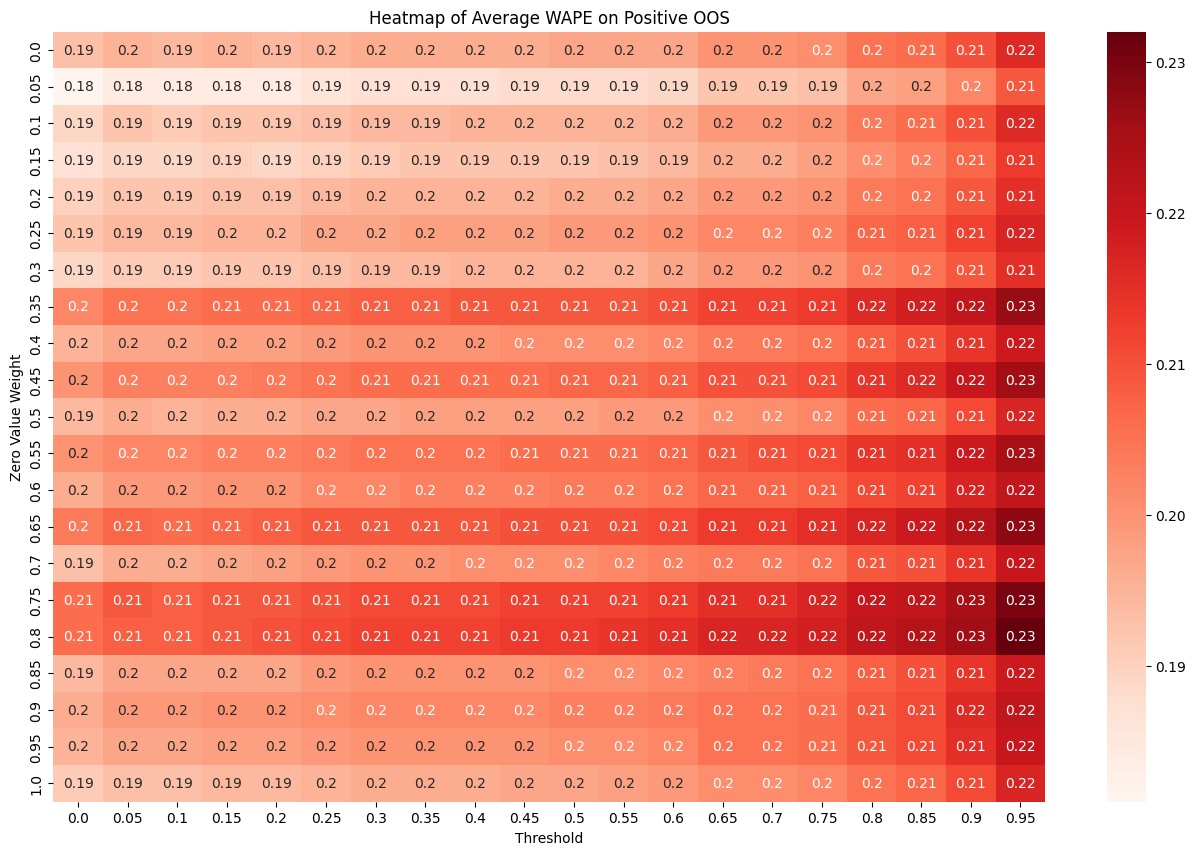

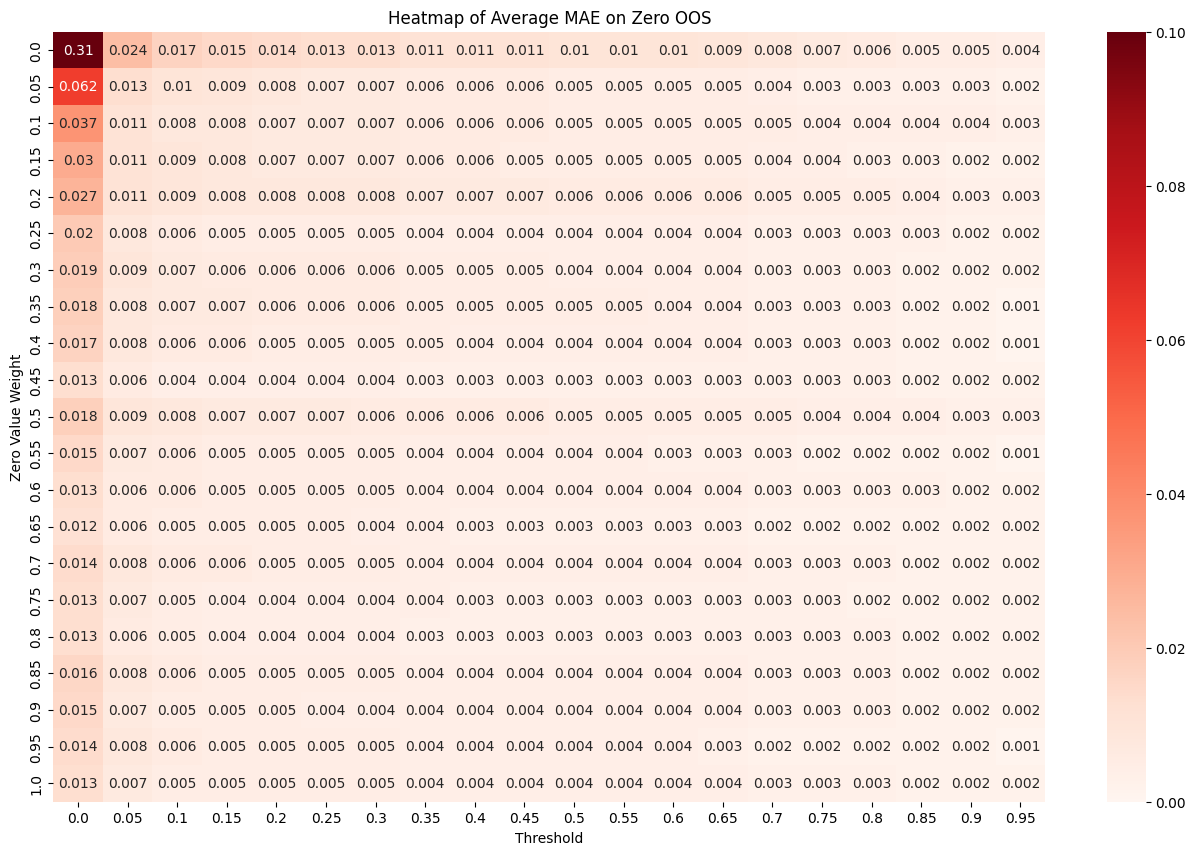

here


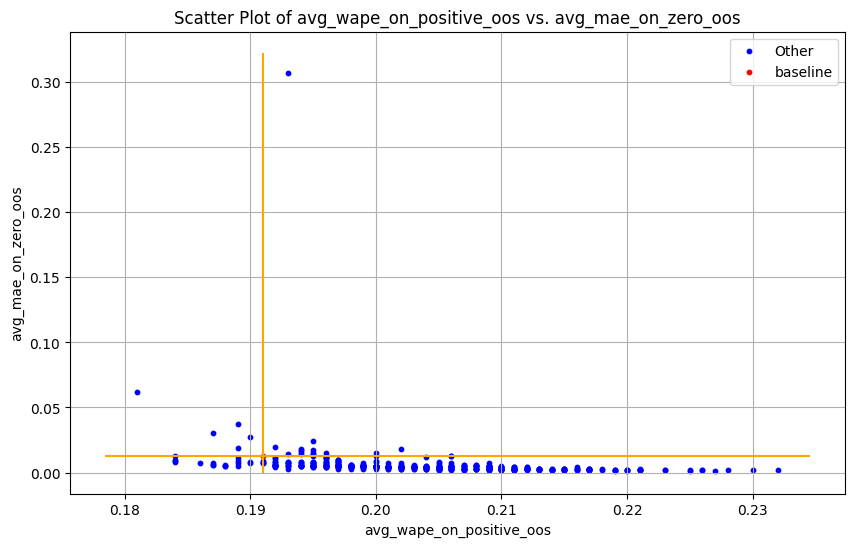

In [ ]:
a = df_res.groupby(['threshold','zero_value_weight']).apply(lambda x:
     pd.Series({'avg_wape_on_positive_oos': x['avg_wape_on_positive_oos'].mean().round(3),
               'avg_mae_on_zero_oos': x['avg_mae_on_zero_oos'].mean().round(3)})
 ).reset_index()
a['threshold'] = a['threshold'].round(2)
a['zero_value_weight'] = a['zero_value_weight'].round(2)

#### heat map
# prompt: for df a, plot the heatmap of avg_wape_on_positive_oos . x axis is threshod, y axis is zero_value_weight . do the same thing for avg_mae_on_zero_oos
import seaborn as sns
import matplotlib.pyplot as plt
# Plot heatmap for avg_wape_on_positive_oos
plt.figure(figsize=(16,10))
# The older syntax:
# pivot_wape = a.pivot("zero_value_weight", "threshold", "avg_wape_on_positive_oos")
# New syntax:
pivot_wape = a.pivot(index="zero_value_weight", columns="threshold", values="avg_wape_on_positive_oos")  # Changed to use keyword arguments
sns.heatmap(pivot_wape, annot=True, cmap="Reds")
plt.title("Heatmap of Average WAPE on Positive OOS")
plt.xlabel("Threshold")
plt.ylabel("Zero Value Weight")
plt.show()


# Plot heatmap for avg_mae_on_zero_oos
plt.figure(figsize=(16, 10))
# The older syntax:
# pivot_mae = a.pivot("zero_value_weight", "threshold", "avg_mae_on_zero_oos")
# New syntax:
pivot_mae = a.pivot(index="zero_value_weight", columns="threshold", values="avg_mae_on_zero_oos")  # Changed to use keyword arguments
sns.heatmap(pivot_mae, annot=True, cmap="Reds", vmin = 0, vmax = 0.1)
plt.title("Heatmap of Average MAE on Zero OOS")
plt.xlabel("Threshold")
plt.ylabel("Zero Value Weight")
plt.show()

#### scatter plot

# Assuming 'a' is the DataFrame as defined in your provided code
# Create the scatter plot
a= a[a['avg_mae_on_zero_oos']<=0.4]
plt.figure(figsize=(10, 6))
for index, row in a.iterrows():
    if row['threshold'] == 0 and row['zero_value_weight'] == 1:
        print('here')
        plt.scatter(row['avg_wape_on_positive_oos'], row['avg_mae_on_zero_oos'], color='red', label='baseline',s = 10 )
        base_x = row['avg_wape_on_positive_oos']
        base_y = row['avg_mae_on_zero_oos']
    else:
        plt.scatter(row['avg_wape_on_positive_oos'], row['avg_mae_on_zero_oos'], color='blue', s= 10, label='Other' if index == 1 else "")

# Get x-axis limits
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Plot the horizontal line with xmin and xmax
plt.hlines(y = base_y, xmin=x_min, xmax=x_max, color = 'orange')  # Added xmin and xmax
plt.vlines(x = base_x, ymin=0, ymax=y_max, color = 'orange')  # Added ymin and ymax

# Customize the plot
plt.xlabel('avg_wape_on_positive_oos')
plt.ylabel('avg_mae_on_zero_oos')
plt.title('Scatter Plot of avg_wape_on_positive_oos vs. avg_mae_on_zero_oos')
plt.legend()
plt.grid(True)
plt.show()



### filter out those effective combinations

In [ ]:
base_res = a[(a['threshold']==0) & (a['zero_value_weight']==1)]
base_wape = base_res['avg_wape_on_positive_oos'].values[0]
base_mae = base_res['avg_mae_on_zero_oos'].values[0]

good_res = a[a['avg_wape_on_positive_oos']<=base_wape]
good_res = good_res[good_res['avg_mae_on_zero_oos']<=base_mae]
good_res = good_res[(good_res['avg_wape_on_positive_oos']< base_wape) | (good_res['avg_mae_on_zero_oos']< base_mae)]
good_res['wape_base'] = base_wape
good_res['mae_base'] = base_mae
good_res['diff_wape'] = -  good_res['avg_wape_on_positive_oos'] + good_res['wape_base']
good_res['diff_mae'] = -  good_res['avg_mae_on_zero_oos'] + good_res['mae_base']

good_res

,threshold,zero_value_weight,avg_wape_on_positive_oos,avg_mae_on_zero_oos,wape_base,mae_base,diff_wape,diff_mae
22,0.05,0.05,0.184,0.013,0.191,0.013,0.007,0.000
24,0.05,0.15,0.189,0.011,0.191,0.013,0.002,0.002
27,0.05,0.30,0.191,0.009,0.191,0.013,0.000,0.004
43,0.10,0.05,0.184,0.010,0.191,0.013,0.007,0.003
44,0.10,0.10,0.191,0.008,0.191,0.013,0.000,0.005
45,0.10,0.15,0.189,0.009,0.191,0.013,0.002,0.004
48,0.10,0.30,0.191,0.007,0.191,0.013,0.000,0.006
64,0.15,0.05,0.184,0.009,0.191,0.013,0.007,0.004
66,0.15,0.15,0.190,0.008,0.191,0.013,0.001,0.005
85,0.20,0.05,0.184,0.008,0.191,0.013,0.007,0.005


### next train on train + val and predict on test data

In [ ]:
##### ok now let's predict on test data using the best threshold and weight

  # X_train, X_temp, y_train, y_temp = train_test_split(
  #     X_data, oos_data, test_size=0.2 # , random_state=random_state
  # )
  # X_val, X_test, y_val, y_test = train_test_split(
  #     X_temp, y_temp, test_size=0.5 #, random_state= random_state
  # )


# combine train and validate data
# X_train_val = np.concatenate([X_train, X_val], axis=0)
# y_train_val = np.concatenate([y_train, y_val], axis=0)

if i == 0:
    input_format = [X_train_val[:, :7], X_train_val[:, 7:14], X_train_val[:, 21:]]
    #val_data = [X_val[:, :7], X_val[:, 7:14], X_val[:, 21:]]
    test_data = [X_test[:, :7], X_test[:, 7:14], X_test[:, 21:]]
elif i == 1:
    input_format = [X_train_val[:, 14:21], X_train_val[:, 7:14], X_train_val[:, 21:]]
    #val_data = [X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
    test_data = [X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]
elif i == 2:
    input_format = [X_train_val[:, :7],X_train_val[:, 14:21], X_train_val[:, 21:]]
    #val_data = [X_val[:, :7],X_val[:, 14:21], X_val[:, 21:]]
    test_data = [X_test[:, :7],X_test[:, 14:21], X_test[:, 21:]]
else:
    input_format = [X_train_val[:, :7], X_train_val[:, 14:21], X_train_val[:, 7:14], X_train_val[:, 21:]]
    #val_data = [X_val[:, :7], X_val[:, 14:21], X_val[:, 7:14], X_val[:, 21:]]
    test_data = [X_test[:, :7], X_test[:, 14:21], X_test[:, 7:14], X_test[:, 21:]]

inputs = []
for input_data in input_format:
    input_layer = layers.Input(shape=(input_data.shape[1],))  # Shape of input_data
    inputs.append(input_layer)



# classification model

y_train_val_class = (y_train_val > 0).astype(int)  # Binary classification for OOS (1 for non-zero OOS, else 0)

#y_test_class = (y_test > 0).astype(int)
df_res_two_fold = []
df_res_base = []

for iter in range(10):

  x = layers.Concatenate()(inputs)

  # Add hidden layers
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(32, activation='relu')(x)

  # Output layer for OOS prediction (7 outputs, one for each day of the week)
  output = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification (0 or 1)

  # Define the model
  classification_model = models.Model(inputs= inputs, outputs=output)
  #classification_model = models.Model(inputs=[order_day_input, lead_time_input, day_of_week_input], outputs=output)

  # Compile the model with binary cross-entropy loss (for multi-label binary classification)
  classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #classification_model.fit([X_train[:, :7], X_train[:, 7:14], X_train[:, 14:]], y_train_class, epochs= 30, batch_size=32, validation_data=([X_val[:, :7], X_val[:, 7:14], X_val[:, 14:]], y_val_class))

  #y_pred_class_prob = classification_model.predict([X_test[:, :7], X_test[:, 7:14], X_test[:, 14:]])  # Predicted probabilities (values between 0 and 1)

  classification_model.fit(input_format, y_train_val_class, epochs= 30, batch_size=32, verbose = 0)

  for threshold, zero_value_weight in good_res[['threshold','zero_value_weight']].values:
    print('threshold', threshold, 'zero_value_weight', zero_value_weight)
  ###### now is regression

    sample_weights = np.where(y_train_val > 0, 1.0, zero_value_weight)

    patience = 10

    cont_flg = True
    while cont_flg == True:

      x = layers.Concatenate()(inputs)
      # Add hidden layers
      x = layers.Dense(128, activation='relu')(x)
      x = layers.Dense(64, activation='relu')(x)
      x = layers.Dense(32, activation='relu')(x)
      output_regression = layers.Dense(1, activation= reg_activation)(x)  # ReLU for regression model
      #regression_model.fit([X_train[:, :7], X_train[:, 7:14], X_train[:, 14:]], y_train, epochs= 30, batch_size=32, sample_weight=sample_weights,validation_data=([X_val[:, :7], X_val[:, 7:14], X_val[:, 14:]], y_val))
      regression_model = models.Model(inputs= inputs, outputs=output_regression)
      regression_model.compile(optimizer='adam', loss= reg_loss )

      no_improvement_count = 0
      best_train_loss = float('inf')
      fail_flg = False

      for epoch in range(25):
              history = regression_model.fit(input_format, y_train_val, epochs=1, batch_size=32, sample_weight = sample_weights, verbose = 0)
              train_loss = history.history['loss'][0]

                # Check if validation loss improved
              if train_loss < best_train_loss:
                  best_train_loss = train_loss
                  no_improvement_count = 0
              else:
                  no_improvement_count += 1

              # Early stopping if no improvement in validation loss for 'patience' epochs
              if no_improvement_count >= patience:
                print(f"Training loss hasn't improved for {patience} epochs. Restarting training.")
                fail_flg = True
                #print('suceed flg is: ', succeed_flg)
                break



      print('fail flg is: ', fail_flg)
      if fail_flg == False:
        cont_flg = False
    ####

    import seaborn as sns
    import matplotlib.pyplot as plt



    import datetime

    ##### now, do the evaluation

    y_pred_class_prob = classification_model.predict(test_data)  # Predicted probabilities (values between 0 and 1) on test data

    y_pred_class = (y_pred_class_prob > threshold).astype(int)  # Convert probabilities to 0 or 1
        # Now, for the data where classification model predicts 1, use the regression model to predict the OOS rate
    mask = (y_pred_class == 1)  # Where classification model predicts 1 (OOS occurred)
    #y_pred_regression = regression_model.predict([X_test[:, :7], X_test[:, 7:14], X_test[:, 14:]])
    y_pred_regression = regression_model.predict(test_data)
    # Replace predictions with regression values only for those where classification model predicted 1
    y_pred_final = np.where(mask, y_pred_regression, 0)  # Set to 0 where classification predicted 0

    # Compute the WAPE and Overprediction Ratio for the test set
    #wape_per_day, overprediction_ratio_per_day = compute_wape_and_overprediction_ratio(y_test, y_pred_final, X_test)
    avg_wape_on_positive_oos,avg_mae_on_zero_oos = compute_wape_and_overprediction_ratio(y_test, y_pred_final, X_test)

    df_temp = pd.DataFrame({ 'avg_wape_on_positive_oos': [avg_wape_on_positive_oos], 'avg_mae_on_zero_oos':[avg_mae_on_zero_oos]})
    df_temp['threshold'] = threshold
    df_temp['zero_value_weight'] = zero_value_weight
    df_temp['iter'] = iter
    df_res_two_fold.append(df_temp)

    print('the model performance of two-step approach is: ',avg_wape_on_positive_oos,avg_mae_on_zero_oos )


    ###### baseline regression
  patience = 10

  cont_flg = True
  while cont_flg == True:

    x = layers.Concatenate()(inputs)
    # Add hidden layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    output_regression = layers.Dense(1, activation= reg_activation)(x)  # ReLU for regression model
    #regression_model.fit([X_train[:, :7], X_train[:, 7:14], X_train[:, 14:]], y_train, epochs= 30, batch_size=32, sample_weight=sample_weights,validation_data=([X_val[:, :7], X_val[:, 7:14], X_val[:, 14:]], y_val))
    regression_model = models.Model(inputs= inputs, outputs=output_regression)
    regression_model.compile(optimizer='adam', loss= reg_loss )


    no_improvement_count = 0
    best_train_loss = float('inf')
    fail_flg = False

    for epoch in range(25):
            history = regression_model.fit(input_format, y_train_val, epochs=1, batch_size=32, verbose = 0)
            train_loss = history.history['loss'][0]

              # Check if validation loss improved
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # Early stopping if no improvement in validation loss for 'patience' epochs
            if no_improvement_count >= patience:
              print(f"Training loss hasn't improved for {patience} epochs. Restarting training.")
              fail_flg = True
              #print('suceed flg is: ', succeed_flg)
              break

    print('fail flg is: ', fail_flg)
    if fail_flg == False:
      cont_flg = False

  y_pred_regression_base = regression_model.predict(test_data)

  avg_wape_on_positive_oos_base,avg_mae_on_zero_oos_base = compute_wape_and_overprediction_ratio(y_test, y_pred_regression_base, X_test)

  df_temp = pd.DataFrame({ 'avg_wape_on_positive_oos': [avg_wape_on_positive_oos_base], 'avg_mae_on_zero_oos':[avg_mae_on_zero_oos]})
  df_temp['iter'] = iter
  df_res_base.append(df_temp)

  #print('the model performance of baseline is: ',avg_wape_on_positive_oos_base,avg_mae_on_zero_oos_base )

    # if (avg_wape_on_positive_oos<= avg_wape_on_positive_oos_base) & (avg_mae_on_zero_oos<= avg_mae_on_zero_oos_base):
    #   if (avg_wape_on_positive_oos< avg_wape_on_positive_oos_base or avg_mae_on_zero_oos < avg_mae_on_zero_oos_base ):
    #     print('doing better than baseline')

df_res_two_fold = pd.concat(df_res_two_fold)
df_res_base = pd.concat(df_res_base)

threshold 0.05 zero_value_weight 0.05
fail flg is:  False
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
the model performance of two-step approach is:  0.18119918649013167 0.019515628
threshold 0.05 zero_value_weight 0.15
fail flg is:  False
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
the model performance of two-step approach is:  0.17012848473874648 0.0037655178
threshold 0.05 zero_value_weight 0.3
fail flg is:  False
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
the model performance of two-step approach is:  0.1935709840487012 0.008982837
threshold 0.1 zero_value_weight 0.05
fail flg is:  False
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
the model performance of two-step approach is:  0.16973710263467728 0.008046268
threshold 0.1 zero_value_weight 0.1
fail flg is:  False
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [ ]:
df_res_two_fold.groupby(['threshold','zero_value_weight']).apply(lambda x:
    pd.Series({'avg_wape_on_positive_oos': x['avg_wape_on_positive_oos'].mean().round(3),
              'avg_mae_on_zero_oos': x['avg_mae_on_zero_oos'].mean().round(3)})
 ).reset_index()

<ipython-input-16-02d28060cdc7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_res_two_fold.groupby(['threshold','zero_value_weight']).apply(lambda x:


,threshold,zero_value_weight,avg_wape_on_positive_oos,avg_mae_on_zero_oos
0,0.00,0.85,0.225,0.021
1,0.05,0.50,0.148,0.011
2,0.05,0.60,0.224,0.018
3,0.10,0.50,0.140,0.005
4,0.15,0.30,0.141,0.019
5,0.15,0.50,0.238,0.004
6,0.15,0.70,0.143,0.009
7,0.20,0.50,0.144,0.009
8,0.25,0.20,0.137,0.010
9,0.30,0.20,0.150,0.011


In [ ]:
df_res_base['avg_wape_on_positive_oos'].mean(), df_res_base['avg_mae_on_zero_oos'].mean()

(np.float64(0.15129783610613), np.float32(0.0120511865))